<h4 style='text-align: center; margin-top:1%'>Tournament theory applied to tennis</h4>
<h4 style='text-align: center; margin-top:1%'></h4>
<h4 style='text-align: center; margin-top:1%'><b>In-depth analysis of the effects of the presence of star(s) in a tennis tournament<b> </h4>

<h4 style='text-align: center; margin-top:1%'>Crésus KOUNOUDJI</h4>

The data we use are ATP tennis rankings, results and statistics from Jeff Sackmann Github: <a href='https://github.com/JeffSackmann/tennis_atp' target='_blank'>JeffSackmann/ATP Tennis</a> where ATP tennis data is compiled from 1968 to the present day.<br><br>
Jeff Sackmann is an author and software developer who has worked in the fields of sports statistics and test preparation.. (source : <a href='http://www.jeffsackmann.com/' target='_blank'>here</a>). 
<br><br>

<b>Description of the data set :</b>

This data set provides information on :

   - atp_matches form 1968 to now: these files contain the main ATP results [There are up to three files per season: one for the main draw matches on the tour (e.g. 'atp_matches_2014.csv'), one for the main draw matches in the qualifiers and challengers on the tour, and one for the matches in the futures tournaments].
   - atp_rankings: contains the historical rankings of ATP players [ranking_date, ranking, player_id, ranking_points (if available)].
   - atp_players : contient les données de base des joueurs ATP [player_id, first_name, last_name, hand, birth_date, country_code, height (cm)].
   - matches_data_dictionary: contains details of the statistics in the main ATP files...

<b>

</b>

### Useful packages

In [91]:
import importlib
from sys import modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from linearmodels.panel import PanelOLS


### I - Extracting, processing and loading data from Github

In [93]:
## Importing pre-coder functions into modules for processing raw git data
%reload_ext autoreload
%autoreload
from modules.data_processor import (process_annual_files, process_ranking_files)

In [3]:
# List of categories to be treated annually
annual_categories = {'atp_matches': range(1980, 2025),}
# Process annual files (from 1980 to 2023)
for category, years_range in annual_categories.items():
    process_annual_files(category, years_range)
#Process rankings files by decade
process_ranking_files()

data//atp_matches_merged.xlsx existe déjà. Processus ignoré.
data//atp_rankings_1970s.xlsx existe déjà. Processus ignoré.


### II - Data processing : Calculation and second series of data transformation for a usable data table

In [94]:
## Importing pre-coder functions into modules for pre-tasking data
%reload_ext autoreload
%autoreload
from modules.data_loader import load_rankings_data
from modules.match_enhanced import enhance_match_data, ensure_type_conversion
from modules.target_modelling import survival_analysis, estimate_and_compare_models
from modules.ranking_star import calculate_points_for_empty_table, build_empty_table
from modules.ranking_star import calculate_cumulative_points, generate_star_atp, generate_yearly_top_stars
from modules.transform_pivot import transform_quant, transform_miss, transform_match_to_player, calculate_effort_measures
from modules.target_modelling import survival_analysis

- Loading match data from tournaments downloaded and compiled between 1990 and 2023

In [5]:
## Loading pre-processed and saved match data by date and by tournament
print("Loading match data...")
df_matches = pd.read_excel('data/atp_matches_merged.xlsx' )
df_rankings = load_rankings_data()

Loading match data...
Chargement des données de classement...


In [6]:
# match data overview
df_matches.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1980-1725,Pepsi Grand Slam,Clay,4,A,08/02/1980,1,100437,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,6.0,NaN,1980
1,1980-1725,Pepsi Grand Slam,Clay,4,A,08/02/1980,2,100342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,1980
2,1980-1725,Pepsi Grand Slam,Clay,4,A,08/02/1980,3,100437,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN,1980


In [7]:
# list of data table columns
df_matches.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'year'],
      dtype='object')

- Calculation of cumulative points over the last 13 tournaments for each player on each date in the points database

In [8]:
# Build the empty table of player point calculations in order to define stars
print("Building the points table...")
df_star_points = build_empty_table(df_matches)
df_star_points.head(3)

Building the points table...


,tourney_date,tourney_name,player_id,player_name
0,1980-02-08,Pepsi Grand Slam,100437,Bjorn Borg
1,1980-02-08,Pepsi Grand Slam,100342,Vitas Gerulaitis
3,1980-02-25,Lagos,100259,Peter Feigl


In [9]:
# Calculating the points for each player in the empty table
df_star_points= calculate_points_for_empty_table(df_star_points, df_matches)
df_star_points.head(3)

,tourney_date,tourney_name,player_id,player_name,points
223856,1982-01-25,Vina del Mar,100010,Luis Ayala,0
219777,1980-01-07,Perth,100013,Neale Fraser,0
1290,1980-10-06,Brisbane,100016,Ken Rosewall,0


In [10]:
# Calculation of points accumulated over the last 13 tournaments
print("Calculation of points accumulated over the last 13 tournaments...")
df_star_points = calculate_cumulative_points(df_star_points, df_matches)
# Keep columns of interest, deleting missing values
star_cols = ['tourney_date', 'tourney_name', 'player_id', 'player_name', 
             'cumulative_points', 'part_points_earned', 'star_method_1', 
             'star_method_2', 'star_method_3', 'is_star', 'max_round']
df_star_points = df_star_points[star_cols].dropna().reset_index(drop=True)
df_star_points.head(3)

Calculation of points accumulated over the last 13 tournaments...


,tourney_date,tourney_name,player_id,player_name,cumulative_points,part_points_earned,star_method_1,star_method_2,star_method_3,is_star,max_round
0,1982-01-25,Vina del Mar,100010,Luis Ayala,0.0,0.0,False,False,False,False,R32
1,1980-10-06,Brisbane,100016,Ken Rosewall,0.0,0.0,False,False,False,False,R16
2,1980-10-06,Brisbane,100016,Ken Rosewall,0.0,0.0,False,False,False,False,R16


- Generate a data table containing the top 5 stars for each draw date and populate the initial match table with this information.

In [11]:
# Generate the star table
print("Star table generation...")
df_top_star = generate_star_atp(df_star_points)
df_top_star.head(3)

Star table generation...


,tourney_date,number_of_stars,top_1_star,top_2_star,top_3_star,top_4_star,top_5_star
0,1980-05-19,2,Guillermo Vilas,Yannick Noah,None,None,None
1,1980-05-26,4,Vitas Gerulaitis,Bjorn Borg,Guillermo Vilas,Yannick Noah,None
2,1980-06-02,4,Trey Waltke,Chris Lewis,Andrew Jarrett,Brad Drewett,None


In [12]:
#Keep only data between 1991 and 2023
df_top_star = df_top_star[(df_top_star.tourney_date >= "1990-01-01") & 
                        (df_top_star.tourney_date <= "2023-12-31")]
df_top_star.head(3)

,tourney_date,number_of_stars,top_1_star,top_2_star,top_3_star,top_4_star,top_5_star
354,1990-01-08,2,Boris Becker,Ivan Lendl,None,None,None
355,1990-01-15,5,Stefan Edberg,Ivan Lendl,Boris Becker,Yannick Noah,Mats Wilander
356,1990-02-05,4,Ivan Lendl,Yannick Noah,John McEnroe,Andrei Cherkasov,None


In [13]:
# Enrich match data with information on stars (number and presence of top 3)
print("Enhancing match data...")
df_matches_enhanced = enhance_match_data(df_matches, df_star_points, df_rankings)
df_matches_enhanced.head(3)

Enhancing match data...


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank,loser_rank_points,year,star_top_1,star_top_2,star_top_3,star_top_4,star_top_5,num_stars_in_tournament,winner_lower_rank
0,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,1,100437,NaN,NaN,...,6.0,NaN,1980,,,,,,0,False
1,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,2,100342,NaN,NaN,...,2.0,NaN,1980,,,,,,0,True
2,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,3,100437,NaN,NaN,...,5.0,NaN,1980,,,,,,0,False


In [14]:
#Keep only data between 1991 and 2023
df_matches_enhanced = df_matches_enhanced[(df_matches_enhanced.tourney_date >= "1990-01-01") & 
                                          (df_matches_enhanced.tourney_date <= "2023-12-31")]
# In any function where df_matches is used, ensure uniqueness
df_matches_enhanced = df_matches_enhanced.drop_duplicates(subset=['tourney_date', 'tourney_name', 'round'])
df_matches_enhanced.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank,loser_rank_points,year,star_top_1,star_top_2,star_top_3,star_top_4,star_top_5,num_stars_in_tournament,winner_lower_rank
36241,1990-339,Adelaide,Hard,32,A,1990-01-01,1,101843,1.0,NaN,...,282.0,70.0,1990,,,,,,0,False
36257,1990-339,Adelaide,Hard,32,A,1990-01-01,17,101843,1.0,NaN,...,146.0,157.0,1990,,,,,,0,False
36265,1990-339,Adelaide,Hard,32,A,1990-01-01,25,101843,1.0,NaN,...,113.0,215.0,1990,,,,,,0,False
36269,1990-339,Adelaide,Hard,32,A,1990-01-01,29,101404,3.0,NaN,...,25.0,591.0,1990,,,,,,0,True
36271,1990-339,Adelaide,Hard,32,A,1990-01-01,31,101404,3.0,NaN,...,88.0,256.0,1990,,,,,,0,False


In [15]:
# Generate the annual table of top 3 stars
print("Generation of the annual table of top 3 stars...")
df_yearly_top_stars = generate_yearly_top_stars(df_star_points)
df_yearly_top_stars.head(3)

Generation of the annual table of top 3 stars...


,year,star_1,star_2,star_3
0,1990,Stefan Edberg,Boris Becker,Andres Gomez
1,1991,Boris Becker,Jim Courier,Stefan Edberg
2,1992,Andre Agassi,Pete Sampras,Stefan Edberg


- Specifying the target and alternating variables to measure player effort

In the pre-processing of the data, I created a variable that measures whether the winner of a match is ranked lower “winner_low_rank” than the loser, in order to measure player “effort” in the tournament. Even if this measure is a conscious choice, it remains arbitrary. It would still be relevant to have other approaches to take into account any heterogeneity that may exist in the expression of a player's effort, for example:

    -> The number of sets won by a lower-ranked player in a match against a higher-ranked player “sets_won_low”.
    -> The number of “dominante” victories, i.e. with a very significant score difference on all “dominante_victory” sets to measure the resistance of the loser.


 ### III - Data mining : exploratory data analysis and third series of Data transformation

#### 3.1- Analysis of missing data and anomalies in Match tables

- Identitfiaction and deletion of columns with too much missing data to be useful without bias

In [16]:
# Definition of a copy of the database for further processing
df_cleaned = df_matches_enhanced.copy()
# Calculation of the number of missing data per column
missing_count = df_cleaned.isna().sum(axis=0)
# Calculation of the proportion of missing data per column
missing_percentage = round((df_cleaned.isna().sum(axis=0) / len(df_cleaned)) * 100,2)
# Columns with more than 10% missing data
columns_to_drop = missing_percentage[missing_percentage > 10].index
print("\nProportion of missing data per column with more than 10% NA : \n")
print(missing_percentage[columns_to_drop])


Proportion of missing data per column with more than 10% NA : 

winner_seed     43.62
winner_entry    93.35
loser_seed      67.15
loser_entry     86.21
minutes         20.87
w_ace           19.09
w_df            19.09
w_svpt          19.09
w_1stIn         19.09
w_1stWon        19.09
w_2ndWon        19.09
w_SvGms         19.09
w_bpSaved       19.09
w_bpFaced       19.09
l_ace           19.09
l_df            19.09
l_svpt          19.09
l_1stIn         19.09
l_1stWon        19.09
l_2ndWon        19.09
l_SvGms         19.09
l_bpSaved       19.09
l_bpFaced       19.09
dtype: float64


Columns with a large number of missing values are completely useless, especially as this hides a systematic non-response which would introduce bias. These columns will have to be managed, as will the rows of those with few missing values, since for a relevant analysis you don't need any at all, but without introducing bias.

- Identify issing data rows in columns where the missing data is reasonable (less than 10% of the total)

In [17]:
# Deletion of lines where the winner_lower_rank interest varibal is missing
df_cleaned = df_cleaned.dropna(subset = ['winner_lower_rank'])
# Removal of unusable columns with too much missing data
df_cleaned= df_cleaned.drop(columns=columns_to_drop)
# Calcul des nouvelles proportion de données manquante
missing_percentage = round((df_cleaned.isna().sum(axis=0) / len(df_cleaned)) * 100,3)
columns_to_treat = missing_percentage[missing_percentage > 0].index
print("\nProportion of missing data per column after deleting significant missing colonnes and rows: \n")
print(missing_percentage[columns_to_treat])


Proportion of missing data per column after deleting significant missing colonnes and rows: 

surface               0.082
winner_ht             1.346
loser_ht              3.358
loser_age             0.007
winner_rank_points    1.312
loser_rank_points     1.312
dtype: float64


    -> There are still 6 columns with very manginal missing data winner_ht(1%), winner_age(0.005%), loser_hand(0.004%), loser_ht(2.5%), loser_age(0.04%), surface(0.032%) and score(0.002%). 
    -> Deleting rows for such a small amount of missing data would, in principle, lead to too great a loss of information, particularly with regard to the other available columns, compared with the error that could be made by mistaking their values. To do this, I'm going to impute values for height and age using the average and for surface types, using the mode.

- Treatment of missing data rows in columns where the missing data is reasonable (less than 10% of the total)

In [18]:
# Marginally missing quantitative variables
quant_miss = ['winner_ht', 'winner_age', 'loser_ht', 'loser_age',
              'winner_rank_points', 'loser_rank_points']
# Marginally missing qualitative variables
qual_miss = ['surface', 'loser_hand', 'score']
# Imputation of missing values by mean and mode
df_cleaned = transform_miss(df_cleaned, quant_miss, qual_miss)
print("\nDataFrame after dealing withn the missing data :")
round((df_cleaned.isna().sum(axis=0) / len(df_cleaned)) * 100,3)


DataFrame after dealing withn the missing data :


tourney_id                 0.0
tourney_name               0.0
surface                    0.0
draw_size                  0.0
tourney_level              0.0
tourney_date               0.0
match_num                  0.0
winner_id                  0.0
winner_name                0.0
winner_hand                0.0
winner_ht                  0.0
winner_ioc                 0.0
winner_age                 0.0
loser_id                   0.0
loser_name                 0.0
loser_hand                 0.0
loser_ht                   0.0
loser_ioc                  0.0
loser_age                  0.0
score                      0.0
best_of                    0.0
round                      0.0
winner_rank                0.0
winner_rank_points         0.0
loser_rank                 0.0
loser_rank_points          0.0
year                       0.0
star_top_1                 0.0
star_top_2                 0.0
star_top_3                 0.0
star_top_4                 0.0
star_top_5                 0.0
num_star

In [19]:
# Perceived characteristics of quantitative realables
round(df_cleaned[["loser_age","winner_age","loser_ht","winner_ht"]].describe(), 2)

,loser_age,winner_age,loser_ht,winner_ht
count,14710.00,14710.00,14710.00,14710.00
mean,25.74,25.62,185.55,185.85
std,3.88,3.76,6.66,6.60
min,15.50,15.80,71.00,3.00
25%,22.90,22.80,180.00,183.00
50%,25.50,25.30,185.00,185.00
75%,28.30,27.90,190.00,190.00
max,41.70,40.10,211.00,211.00


It seems surprising to see a 71cm player, but after checking "Viacheslav Bielinskyi" is really 2'4" (71cm).

- Ensuring that tournaments are unique

In [20]:
#Nombre de données restantes 
print("Number of unique tournaments in the database : ", len(df_cleaned.tourney_name.drop_duplicates()))
print("Number of matches in the database: ", len(df_cleaned.tourney_name),"\n")
df_cleaned.tourney_name.drop_duplicates()

Number of unique tournaments in the database :  2099
Number of matches in the database:  14710 



36241                         Adelaide
36272                       Wellington
36303                         Auckland
36334                   Sydney Outdoor
36365                  Australian Open
                      ...             
145199    Davis Cup WG2 PO: EGY vs PAR
145206    Davis Cup WG2 PO: EST vs JAM
145210    Davis Cup WG2 PO: INA vs VIE
145214    Davis Cup WG2 PO: RSA vs LUX
145218    Davis Cup WG2 PO: TUN vs CYP
Name: tourney_name, Length: 2099, dtype: object

There seems to be an inconsistency between the number of unique tournaments in the database and what you'd expect to have. After a quick look at the list of tournament names, you can see, for example, that each Davis Cup match is considered to be a tournament in the database. I'm going to replace the tournament name of Devis Cup matches with just "Devis Cup". Furthermore, given that the Devis Cup is a Team tournament, it would be interesting to flag this state to take it into account in our analysis.

In [21]:
# Replace tournament names containing "Davis Cup" with "Davis Cup".
df_cleaned['tourney_name'] = df_cleaned['tourney_name'].str.replace(r'Davis Cup.*', 'Davis Cup', regex=True)
# List of team tournaments
team_tournaments = ['Davis Cup', 'ATP Cup', 'United Cup', 'Laver Cup']
# Create a dichotomous column indicating whether the macth is a team player or not 
# # (depending on whether it is in one of these tournaments).
# df_cleaned['in_team'] = df_cleaned['tourney_name'].apply(lambda x: 1 if x in team_tournaments else 0)
# Name of base tournaments
df_cleaned.tourney_name.drop_duplicates()

# Number of data
print("Number of unique tournaments in the database: ", len(df_cleaned.tourney_name.drop_duplicates()))
print("Number of matches in the database: ", len(df_cleaned.tourney_name))
# print("Number of team matches : ", sum(df_cleaned.in_team),"\n")
df_cleaned.tourney_name.drop_duplicates()

Number of unique tournaments in the database:  218
Number of matches in the database:  14710


36241            Adelaide
36272          Wellington
36303            Auckland
36334      Sydney Outdoor
36365     Australian Open
               ...       
141773              Gijon
141800             Naples
142236         United Cup
142716     Rio De Janeiro
143263         Banja Luka
Name: tourney_name, Length: 218, dtype: object

In [22]:
# Proportion de chaque tournoi
tourney_counts = df_cleaned['tourney_name'].value_counts()
total_matches = len(df_cleaned['tourney_name'])
tourney_proportion = round(tourney_counts / total_matches * 100, 2)
print("Occurrence of tournaments in the database by number of matches  : ","\n", tourney_proportion,"\n")


Occurrence of tournaments in the database by number of matches  :  
 Davis Cup             13.62
Roland Garros          1.62
Australian Open        1.62
Wimbledon              1.56
Miami Masters          1.56
                      ...  
Itaparica              0.03
ATP Rio de Janeiro     0.03
Banja Luka             0.03
Split                  0.03
United Cup             0.02
Name: tourney_name, Length: 218, dtype: float64 



    -> The Davis Cup team tournament matches are over-represented in the database if other tournaments are taken one by one, but under-represented if grouped by individual vs team tournaments. I think it would be more prudent to make a separate analysis for individual matches and team matches.

#### 3.2- Statistics Describes the data in the cleaned matches table

- Tournaments represented in the database by the various matches over the period in question

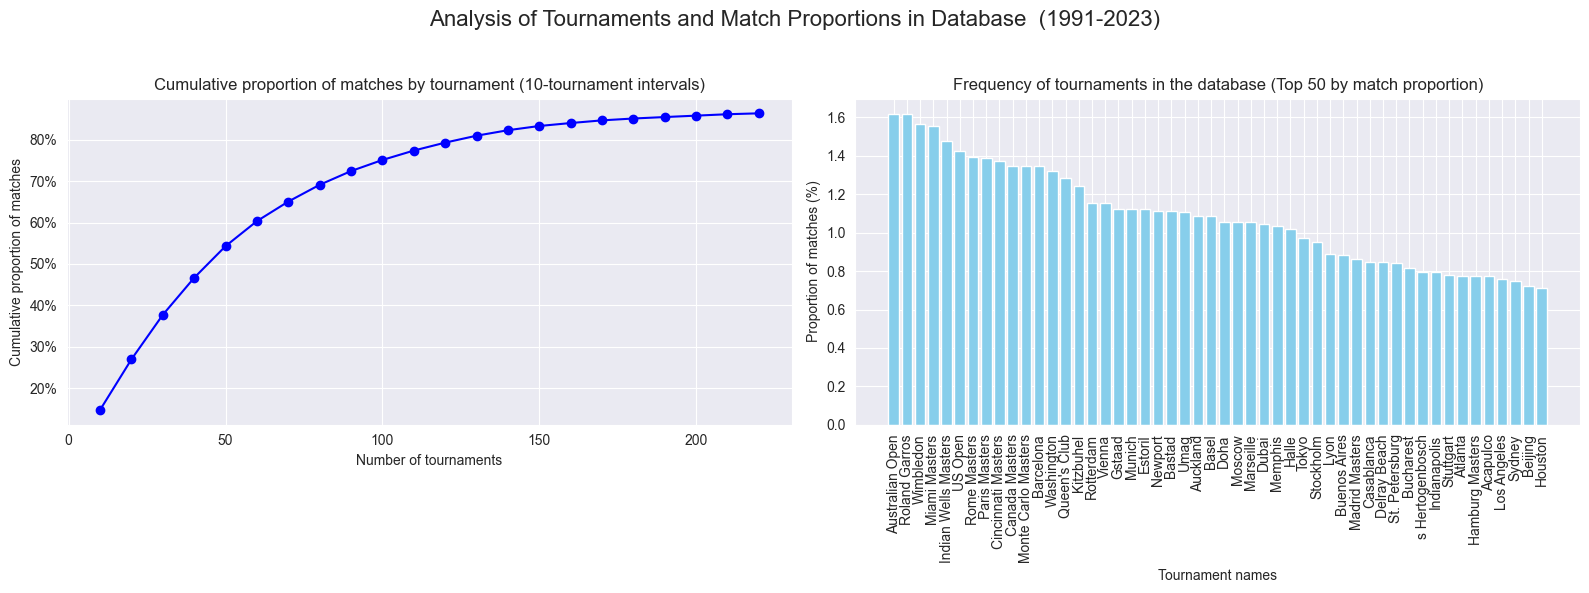

In [23]:
# Calculating the number of matches for individual tournaments
tourney_counts = df_cleaned[df_cleaned['tourney_name']!="Davis Cup"]['tourney_name'].value_counts()
total_matches = len(df_cleaned['tourney_name'])
step_size = 10  #Interval size for cumulative analysis of tournaments
# Calculation of cumulative proportions for each interval of 10 tournaments
proportions = [tourney_counts.head(i).sum() / total_matches for i in range(step_size, len(tourney_counts) + step_size, step_size)]
x_labels = list(range(step_size, len(tourney_counts) + step_size, step_size))
# Proportion of each tournament (top 50)
tourney_proportion = tourney_counts.head(50) / total_matches * 100
# Création des sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Analysis of Tournaments and Match Proportions in Database  (1991-2023)", fontsize=16)
# Chart 1: Cumulative proportion of matches by number of tournaments (per 10 tournaments)
axes[0].plot(x_labels, proportions, marker='o', linestyle='-', color='b')
axes[0].set_xlabel('Number of tournaments')
axes[0].set_ylabel('Cumulative proportion of matches')
axes[0].set_title('Cumulative proportion of matches by tournament (10-tournament intervals)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].grid(True)
# Graph 2: Proportion of tournaments in the database (Top 50)
axes[1].bar(tourney_proportion.index, tourney_proportion.values, color='skyblue')
axes[1].set_title("Frequency of tournaments in the database (Top 50 by match proportion)")
axes[1].set_ylabel("Proportion of matches (%)")
axes[1].set_xlabel("Tournament names")
axes[1].tick_params(axis='x', rotation=90)
# Adjusting the display to avoid overlaps
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

    -> We can see that by selecting the tournaments with the most matches in the database, only half of the tournaments are needed to concentrate more than 92% of the data. So, without any significant loss of data, we could concentrate on the first 150 tournaments with the most data. I can therefore remove tournaments with fewer than 16 participants without fear of losing too much data.
    -> It appears that the Davis Cup, which is a team tournament, is fairly well represented in terms of the number of matches compared with the others. Other major tournaments such as Rolland Garros are also well represented in the database.
    -> It appears that these tournaments could be grouped by type to try to take account of the heterogeneity of the type of tournament (master, Davis Cup, etc.) on the effects measured. The "Tourney Level" variable already plays this role, so we won't need it.


- Show distribution of cumulative points per player

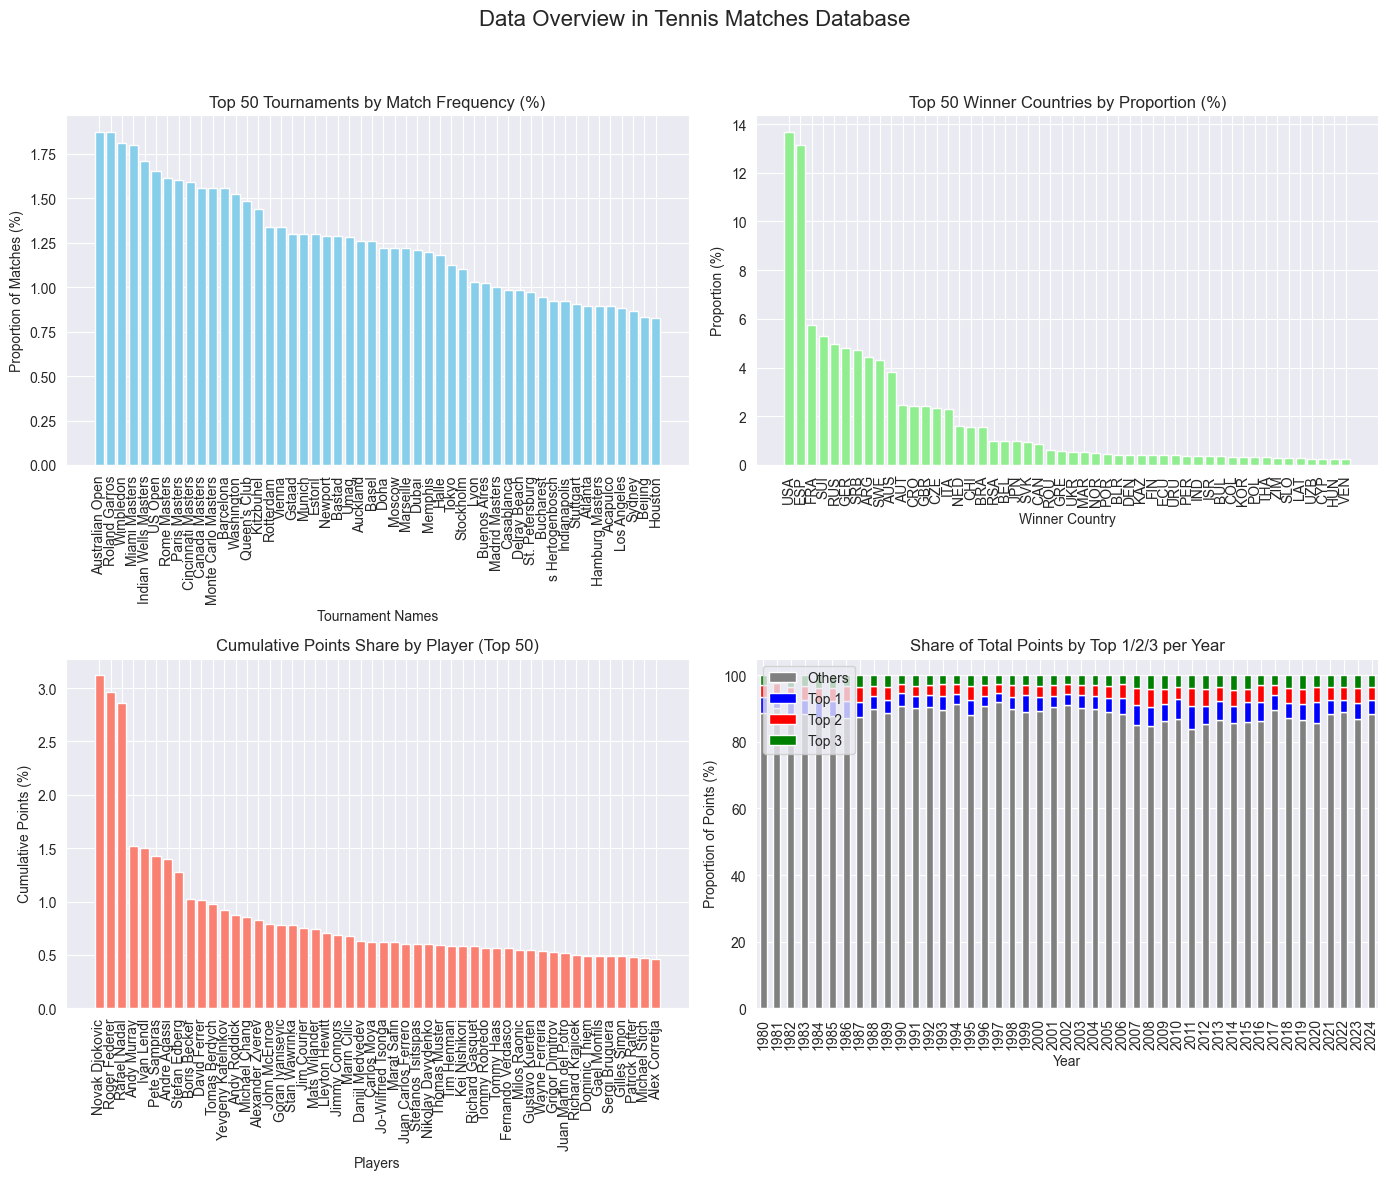

In [24]:
# Creation of sub-graphs
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Data Overview in Tennis Matches Database", fontsize=16)
# Graph 1: Distribution of tournaments in the database (Top 50)
tourney_proportion = df_cleaned[df_cleaned['tourney_name']!="Davis Cup"]['tourney_name'].value_counts(normalize=True)[:50] * 100
axes[0, 0].bar(tourney_proportion.index, tourney_proportion.values, color='skyblue')
axes[0, 0].set_title("Top 50 Tournaments by Match Frequency (%)")
axes[0, 0].set_ylabel("Proportion of Matches (%)")
axes[0, 0].set_xlabel("Tournament Names")
axes[0, 0].tick_params(axis='x', rotation=90)
# Graph 2: Distribution of winners' countries in the database (Top 50)
ioc_proportion = df_cleaned['winner_ioc'].value_counts(normalize=True)[:50] * 100
axes[0, 1].bar(ioc_proportion.index, ioc_proportion.values, color='lightgreen')
axes[0, 1].set_title("Top 50 Winner Countries by Proportion (%)")
axes[0, 1].set_ylabel("Proportion (%)")
axes[0, 1].set_xlabel("Winner Country")
axes[0, 1].tick_params(axis='x', rotation=90)
# Graph 3: Distribution of cumulative points per player (Top 50 players)
df_points_sum = df_star_points.groupby('player_name')['cumulative_points'].sum()
df_points_sum = df_points_sum.sort_values(ascending=False).reset_index()
df_points_sum['cumulative_points_part'] = df_points_sum['cumulative_points'] / df_points_sum['cumulative_points'].sum() * 100
axes[1, 0].bar(df_points_sum['player_name'].head(50), df_points_sum['cumulative_points_part'].head(50), color='salmon')
axes[1, 0].set_title("Cumulative Points Share by Player (Top 50)")
axes[1, 0].set_ylabel("Cumulative Points (%)")
axes[1, 0].set_xlabel("Players")
axes[1, 0].tick_params(axis='x', rotation=90)
# Graph 4: Breakdown of points by year for Top 1, 2, 3 and others
df_yearly_points = df_star_points.copy()
df_yearly_points['year'] = df_yearly_points['tourney_date'].dt.year
yearly_points = df_yearly_points.groupby(['year', 'player_name']).agg({'cumulative_points': 'max'}).reset_index()
total_points_by_year = yearly_points.groupby('year')['cumulative_points'].sum()
data = []
for year, group in yearly_points.groupby('year'):
    group_sorted = group.sort_values(by='cumulative_points', ascending=False)
    top1 = group_sorted.iloc[0]['cumulative_points'] if len(group_sorted) > 0 else 0
    top2 = group_sorted.iloc[1]['cumulative_points'] if len(group_sorted) > 1 else 0
    top3 = group_sorted.iloc[2]['cumulative_points'] if len(group_sorted) > 2 else 0
    others = total_points_by_year[year] - (top1 + top2 + top3)
    data.append({
        'year': year,
        'Others': others / total_points_by_year[year] * 100,
        'Top 1': top1 / total_points_by_year[year] * 100,
        'Top 2': top2 / total_points_by_year[year] * 100,
        'Top 3': top3 / total_points_by_year[year] * 100
    })
df_plot = pd.DataFrame(data).set_index('year')
df_plot.plot(kind='bar', stacked=True, color=['grey', 'blue', 'red', 'green'], ax=axes[1, 1])
axes[1, 1].set_title("Share of Total Points by Top 1/2/3 per Year")
axes[1, 1].set_ylabel("Proportion of Points (%)")
axes[1, 1].set_xlabel("Year")
axes[1, 1].legend(['Others', 'Top 1', 'Top 2', 'Top 3'], loc='upper left')
# Adjusting the global display
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the overall title
plt.show()

    -> This graph corroborates the previous one.
    -> It would be interesting to group together the different countries in order to incorporate a certain heterogeneity of victory in the winner/loser's country of origin.

- Visualisation of the domination of tennis by a small number of players, the "Stars" according to my calculations

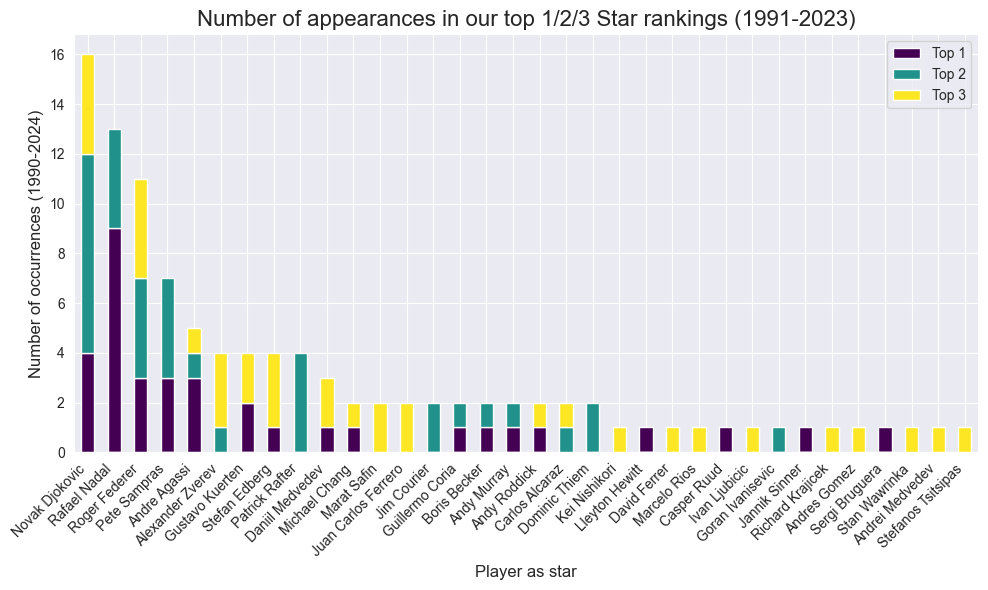

In [25]:
# Top 1/2/3 star dominance by players between 1990 and 2024 according to our rankings
# Concatenate stars into a single DataFrame for easier counting
df_melted = pd.melt(df_yearly_top_stars, id_vars='year', value_vars=['star_1', 'star_2', 'star_3'], 
                    var_name='rank', value_name='player')
# Count the number of times each player is ranked in the top 1, 2 or 3 positions
df_count = df_melted.groupby(['player', 'rank']).size().unstack(fill_value=0)
# Rename columns for clearer display
df_count.columns = ['Top 1', 'Top 2', 'Top 3']
# Add a column with the total number of appearances for each player
df_count['Total'] = df_count.sum(axis=1)
# Sort players by total appearances in the top 1/2/3
df_count_sorted = df_count.sort_values(by='Total', ascending=False)
# Delete the 'Total' column before plotting the graph
df_count_sorted = df_count_sorted.drop(columns='Total')
# Generate a histogram for each sorted player
df_count_sorted.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
# Add labels and a title
plt.title("Number of appearances in our top 1/2/3 Star rankings (1991-2023)", fontsize=16)
plt.ylabel("Number of occurrences (1990-2024)", fontsize=12)
plt.xlabel("Player as star", fontsize=12)
plt.xticks(rotation=45, ha='right')
# Afficher le graphique
plt.tight_layout()
plt.show()

It's pretty obvious that Djokovic, Nadal and Federer have dominated our star rankings over the last 30 years. It would therefore be interesting not only to see the effect of the stars' presence, but also to isolate the effect of their presence, for example, compared to other stars.

- Viewing match playing surfaces,  Number of Stars in Tournament, tourney level and Dominant Hands Among Winners in the database

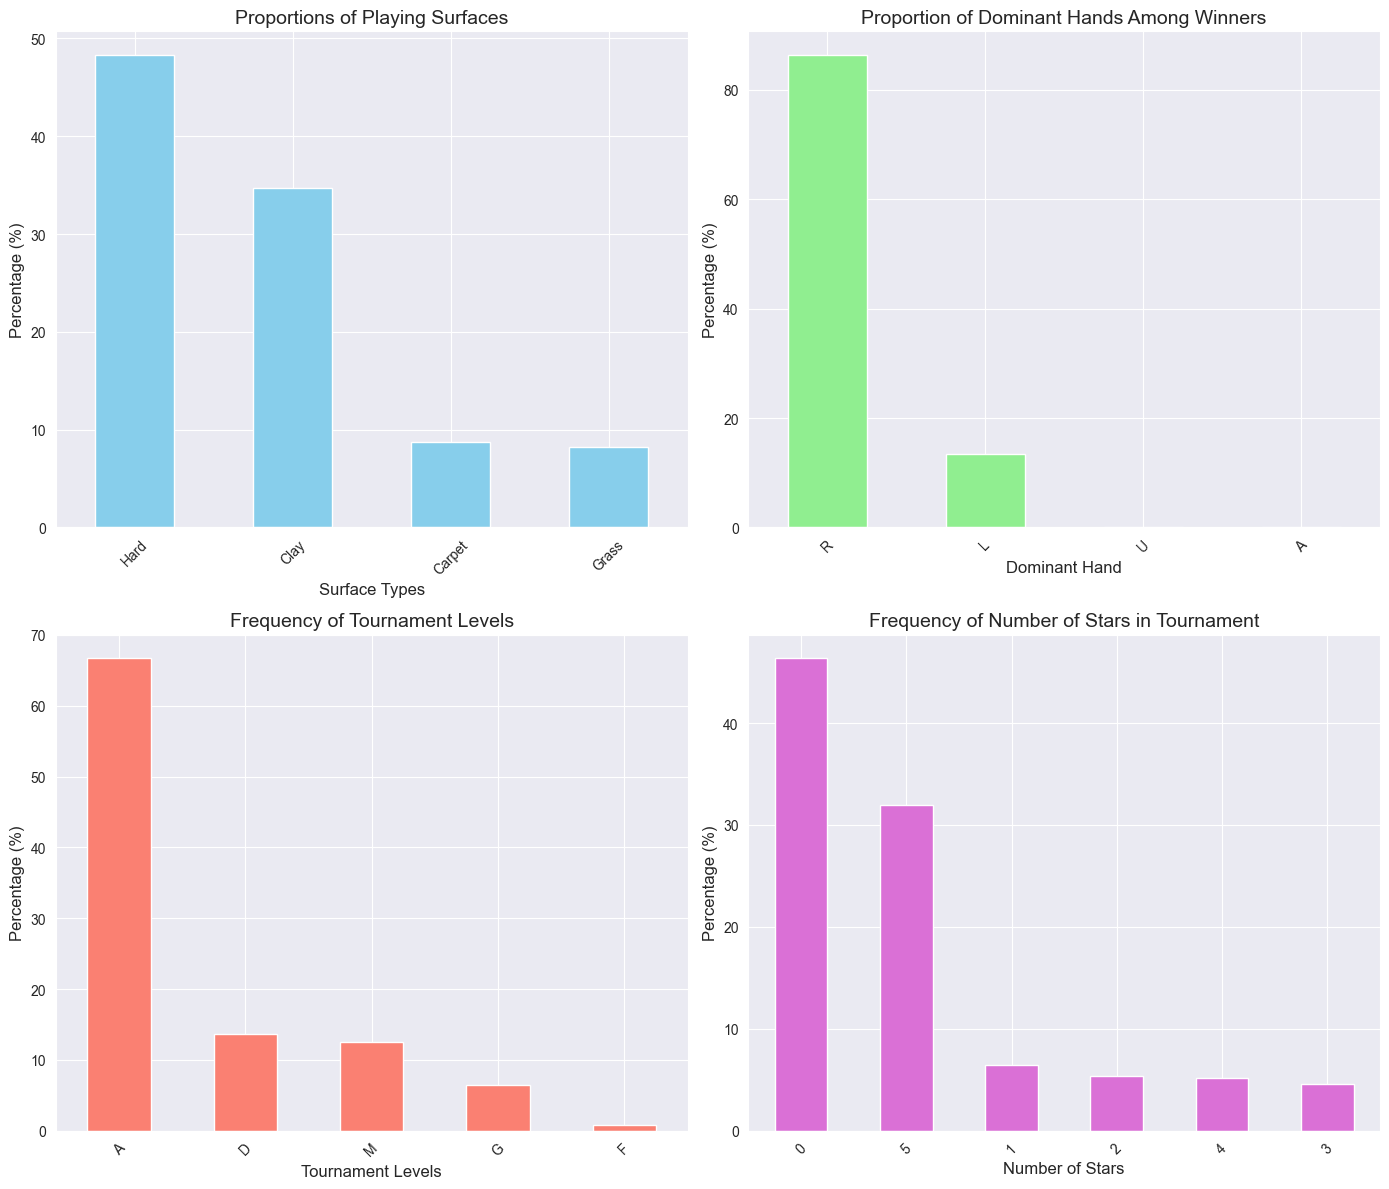

In [26]:
# Calculation of proportions for each category
surface_proportion = df_cleaned['surface'].value_counts(normalize=True) * 100
hand_proportion = df_cleaned['winner_hand'].value_counts(normalize=True) * 100
tourney_level_proportion = df_cleaned['tourney_level'].value_counts(normalize=True) * 100
stars_proportion = (df_cleaned[['tourney_date','tourney_name','num_stars_in_tournament']].groupby(
    ['tourney_date','tourney_name']).max())['num_stars_in_tournament'].value_counts(normalize=True) * 100
# Creation of the figure with 4 sub-graphs
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
# Figure 1: Proportions of playing surfaces
surface_proportion.plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title("Proportions of Playing Surfaces", fontsize=14)
axes[0, 0].set_ylabel("Percentage (%)", fontsize=12)
axes[0, 0].set_xlabel("Surface Types", fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45)
# Graph 2: Proportion of dominant hands among winners
hand_proportion.plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title("Proportion of Dominant Hands Among Winners", fontsize=14)
axes[0, 1].set_ylabel("Percentage (%)", fontsize=12)
axes[0, 1].set_xlabel("Dominant Hand", fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45)
# Graph 3: Proportion of tournament levels
tourney_level_proportion.plot(kind='bar', ax=axes[1, 0], color='salmon')
axes[1, 0].set_title("Frequency of Tournament Levels", fontsize=14)
axes[1, 0].set_ylabel("Percentage (%)", fontsize=12)
axes[1, 0].set_xlabel("Tournament Levels", fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
# Graph 4: Proportion of stars per tournament
stars_proportion.plot(kind='bar', ax=axes[1, 1], color='orchid')
axes[1, 1].set_title("Frequency of Number of Stars in Tournament", fontsize=14)
axes[1, 1].set_ylabel("Percentage (%)", fontsize=12)
axes[1, 1].set_xlabel("Number of Stars", fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
# Adjusting the display to avoid overlaps
plt.tight_layout()
plt.show()


    -> Grass" and "Carpet" surfaces are not very well represented. We could group them together in a single class to be sure of measuring a statistical effect, if there is one.
    -> This graph shows the maginality of ambidextrous people but also the absence of dominant hand knowledge for a small number. 
    These classes are of no statistical interest. Since they may become one, if there is an advantage in doing so, I will classify ambidestrians as left-handed and impute the "U" lines which mean that the dominant hand is unknown.
    -> The F-level tournaments are marginal, so I'm going to group them with the D-level tournaments.


- Age and Height distribution of losers and winners

In [27]:
print("tourney_level_proportion: /n",tourney_level_proportion)
print("surface_proportion: /n",surface_proportion)
print("stars_proportion: /n",stars_proportion)
print("hand_proportion: /n",hand_proportion)


tourney_level_proportion: /n A    66.709721
D    13.616587
M    12.488103
G     6.417403
F     0.768185
Name: tourney_level, dtype: float64
surface_proportion: /n Hard      48.307274
Clay      34.731475
Carpet     8.721958
Grass      8.239293
Name: surface, dtype: float64
stars_proportion: /n 0    46.368084
5    31.990967
1     6.473466
2     5.382010
4     5.193828
3     4.591645
Name: num_stars_in_tournament, dtype: float64
hand_proportion: /n R    86.369816
L    13.487424
U     0.135962
A     0.006798
Name: winner_hand, dtype: float64


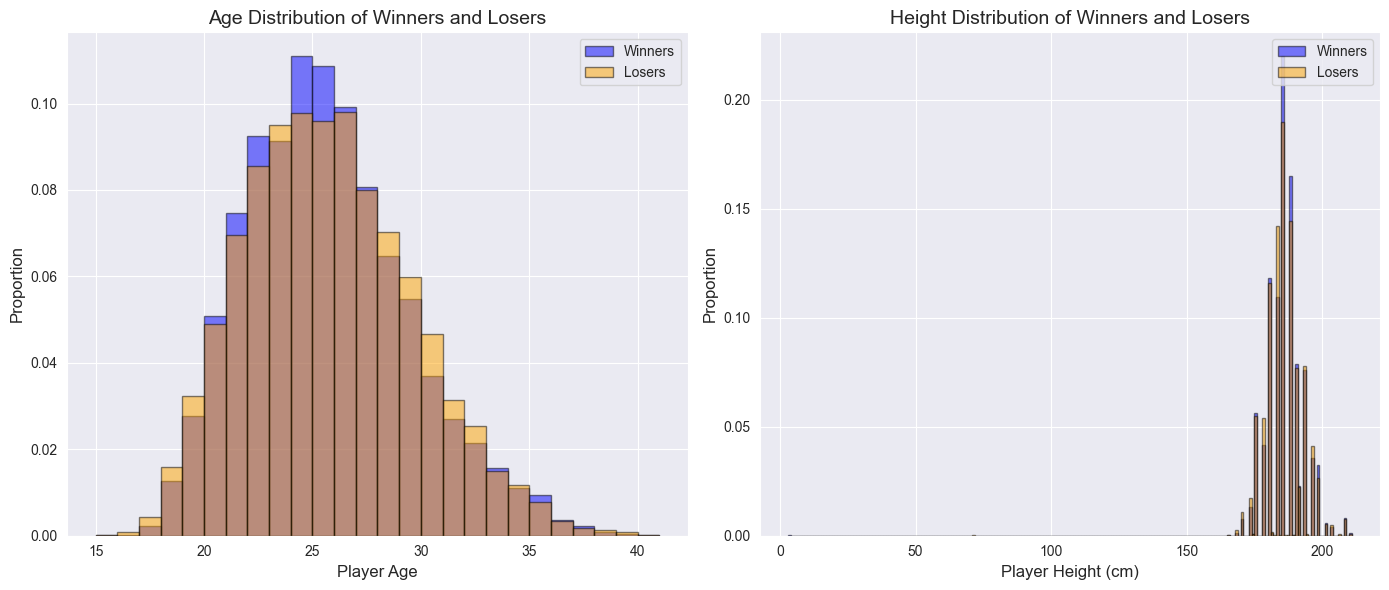

In [28]:
# Bins can be adjusted to suit different ages and height
age_bins = range(
    int(min(df_cleaned['winner_age'].min(), df_cleaned['loser_age'].min())),
    int(max(df_cleaned['winner_age'].max(), df_cleaned['loser_age'].max()) + 1)
)
height_bins = range(
    int(min(df_cleaned['winner_ht'].min(), df_cleaned['loser_ht'].min())),
    int(max(df_cleaned['winner_ht'].max(), df_cleaned['loser_ht'].max()) + 1)
)
# Creation of a figure with two sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Proportional age distribution of winners and losers
axes[0].hist(df_cleaned['winner_age'], bins=age_bins, alpha=0.5, label='Winners', color='blue', edgecolor='black', density=True)
axes[0].hist(df_cleaned['loser_age'], bins=age_bins, alpha=0.5, label='Losers', color='orange', edgecolor='black', density=True)
axes[0].set_xlabel('Player Age', fontsize=12)
axes[0].set_ylabel('Proportion', fontsize=12)
axes[0].set_title('Age Distribution of Winners and Losers', fontsize=14)
axes[0].legend(loc='upper right', fontsize=10)
# Height distribution of winners and losers in proportions
axes[1].hist(df_cleaned['winner_ht'], bins=height_bins, alpha=0.5, label='Winners', color='blue', edgecolor='black', density=True)
axes[1].hist(df_cleaned['loser_ht'], bins=height_bins, alpha=0.5, label='Losers', color='orange', edgecolor='black', density=True)
axes[1].set_xlabel('Player Height (cm)', fontsize=12)
axes[1].set_ylabel('Proportion', fontsize=12)
axes[1].set_title('Height Distribution of Winners and Losers', fontsize=14)
axes[1].legend(loc='upper right', fontsize=10)
# Adjusting the display to avoid overlaps
plt.tight_layout()
plt.show()

##### 3.3- Creation of new variables and adjustment of existing variables

- Creation of variables to identify the presence of Nadal, Federer or Djokovic as stars in a tournament.

In [29]:
# Add columns for Rafael Nadal, Roger Federer, and Novak Djokovic
column_top_star  = ['star_top_1', 'star_top_2', 'star_top_3', 'star_top_4', 'star_top_5']
df_cleaned = df_cleaned.copy()
# Nadal as star
df_cleaned['Rafael_Nadal_star'] = df_cleaned[column_top_star].apply(
    lambda x: 1 if 'Rafael Nadal' in x.values else 0, axis=1)
# Federer as star
df_cleaned['Roger_Federer_star'] = df_cleaned[column_top_star].apply(
    lambda x: 1 if 'Roger Federer' in x.values else 0, axis=1)
# Djokkovic as star
df_cleaned['Novak_Djokovic_star'] = df_cleaned[column_top_star].apply(
    lambda x: 1 if 'Novak Djokovic' in x.values else 0, axis=1)
# Add the Others_star column
df_cleaned['Others_star'] = df_cleaned[column_top_star].apply(
    lambda x: 1 if any(star not in ['Rafael Nadal', 'Roger Federer', 'Novak Djokovic', ''] for star in x.values) else 0,
    axis=1)
# Display the DataFrame with the new columns
df_cleaned= df_cleaned.drop(column_top_star, axis=1)
df_cleaned.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,winner_rank_points,loser_rank,loser_rank_points,year,num_stars_in_tournament,winner_lower_rank,Rafael_Nadal_star,Roger_Federer_star,Novak_Djokovic_star,Others_star
36241,1990-339,Adelaide,Hard,32,A,1990-01-01,1,101843,Sergi Bruguera,R,...,591.0,282.0,70.0,1990,0,False,0,0,0,0
36257,1990-339,Adelaide,Hard,32,A,1990-01-01,17,101843,Sergi Bruguera,R,...,591.0,146.0,157.0,1990,0,False,0,0,0,0
36265,1990-339,Adelaide,Hard,32,A,1990-01-01,25,101843,Sergi Bruguera,R,...,591.0,113.0,215.0,1990,0,False,0,0,0,0


- Creation of a variable for age and height differences between winners and losers

In [30]:
# Add a column that calculates the height difference between the winner and the loser
df_cleaned['height_diff'] = df_cleaned['winner_ht'] - df_cleaned['loser_ht']
# Add a column that calculates the height difference between the winner and the loser
df_cleaned['age_diff'] = df_cleaned['winner_age'] - df_cleaned['loser_age']

- Ajustement des valeurs de la variable de main dominante

In [31]:
# Adjust the 'A' (Ambidestre) values in the 'winner_hand' column to the 'L' (left-handed) values
df_cleaned['winner_hand'] = df_cleaned['winner_hand'].replace('A', 'L')
# Charge lines where 'winner_hand' is 'U
df_cleaned['winner_hand'] = df_cleaned['winner_hand'].replace('U', np.nan)
hand_mode = df_cleaned['winner_hand'].mode().iloc[0] if not df_cleaned['winner_hand'].mode().empty else np.nan
df_cleaned['winner_hand']= df_cleaned['winner_hand'].fillna(hand_mode)
# Check proportion after cleaning
hand_proportion = df_cleaned['winner_hand'].value_counts(normalize=True)*100
print("\nProportions after adjustment:")
print(hand_proportion)


Proportions after adjustment:
R    86.505778
L    13.494222
Name: winner_hand, dtype: float64


In [32]:
# Adjust the 'A' (Ambidestre) values in the 'loser_hand' column to the 'L' (left-handed) values
df_cleaned['loser_hand'] = df_cleaned['loser_hand'].replace('A', 'L')
# Charge lines where 'loser_hand' is 'U
df_cleaned['loser_hand'] = df_cleaned['loser_hand'].replace('U', np.nan)
hand_mode = df_cleaned['loser_hand'].mode().iloc[0] if not df_cleaned['loser_hand'].mode().empty else np.nan
df_cleaned['loser_hand']= df_cleaned['loser_hand'].fillna(hand_mode)
# Check proportion after cleaning
hand_proportion = df_cleaned['loser_hand'].value_counts(normalize=True)*100
print("\nProportions after adjustment:")
print(hand_proportion)


Proportions after adjustment:
R    86.186268
L    13.813732
Name: loser_hand, dtype: float64


- Adjusting the values of the playing surface variable

In [33]:
# Adjust the "Grass" and "Carpet" values in the "surface" column to the "Grass/Carpet" values
df_cleaned['surface'] = df_cleaned['surface'].replace('Grass', 'Grass/Carpet')
df_cleaned['surface'] = df_cleaned['surface'].replace('Carpet', 'Grass/Carpet')
# Check proportion after cleaning
surface_proportion = df_cleaned['surface'].value_counts(normalize=True)*100
print("\nProportions after adjustment: ")
print(surface_proportion)


Proportions after adjustment: 
Hard            48.307274
Clay            34.731475
Grass/Carpet    16.961251
Name: surface, dtype: float64


- Adjusting the values of the tourney level variable

In [34]:
# Adjust the "Grass" and "Carpet" values in the "surface" column to the "Grass/Carpet" values
df_cleaned['tourney_level'] = df_cleaned['tourney_level'].replace('D', 'D/F')
df_cleaned['tourney_level'] = df_cleaned['tourney_level'].replace('F', 'D/F')

# Check proportion after cleaning
hand_proportion = df_cleaned['tourney_level'].value_counts(normalize=True)*100
print("\nProportions after adjustment:")
print(hand_proportion)


Proportions after adjustment:
A      66.709721
D/F    14.384772
M      12.488103
G       6.417403
Name: tourney_level, dtype: float64


- Adjustment of the 'ioc' variable to group country codes into world region groups

In [35]:
# Calculate the proportions for each mode in 'winner_ioc'.
ioc_proportion = df_cleaned['winner_ioc'].value_counts(normalize=True) * 100
# Creation of a grouping dictionary based on proportions
grouping_dict = {}
for ioc, proportion in ioc_proportion.items():
    if proportion >= 7:  # for USA, ESP, FRA
        grouping_dict[ioc] = 'USA-ESP-FRA'
    elif 2.5 <= proportion < 7:  # for GER, ARG, SWE, AUS, RUS, ITA, CZE, SUI
        grouping_dict[ioc] = 'GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI'
    else:  # for others
        grouping_dict[ioc] = 'Others_IOC'
# Apply grouping to 'winner_ioc' to create 'winner_ioc_grouped'.
df_cleaned['winner_ioc_grouped'] = df_cleaned['winner_ioc'].map(grouping_dict)
# Display the proportions of the new terms and conditions for verification
new_ioc_proportion = df_cleaned['winner_ioc_grouped'].value_counts(normalize=True) * 100
print("\nProportion of terms grouped together :")
print(new_ioc_proportion)


# Calculate the proportions for each mode in 'loser_ioc'.
ioc_proportion = df_cleaned['loser_ioc'].value_counts(normalize=True) * 100
# Creation of a grouping dictionary based on proportions
grouping_dict = {}
for ioc, proportion in ioc_proportion.items():
    if proportion >= 7:  # for USA, ESP, FRA
        grouping_dict[ioc] = 'USA-ESP-FRA'
    elif 2.5 <= proportion < 7:  # for GER, ARG, SWE, AUS, RUS, ITA, CZE, SUI
        grouping_dict[ioc] = 'GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI'
    else:  # for others
        grouping_dict[ioc] = 'Others_IOC'
# Apply grouping to 'loser_ioc' to create 'winner_ioc_grouped'.
df_cleaned['loser_ioc_grouped'] = df_cleaned['loser_ioc'].map(grouping_dict)
# Display the proportions of the new terms and conditions for verification
new_ioc_proportion = df_cleaned['loser_ioc_grouped'].value_counts(normalize=True) * 100
print("\nProportion of terms grouped together :")
print(new_ioc_proportion)




Proportion of terms grouped together :
GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI    38.103331
Others_IOC                         35.091774
USA-ESP-FRA                        26.804895
Name: winner_ioc_grouped, dtype: float64

Proportion of terms grouped together :
Others_IOC                         41.434398
GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI    30.020394
USA-ESP-FRA                        28.545207
Name: loser_ioc_grouped, dtype: float64


- Adjustment of multimodal qualitative variables to give them the "category" type

In [36]:
df_cleaned[['surface','tourney_level','round', 'best_of','num_stars_in_tournament', 'winner_ioc_grouped']] = df_cleaned[
    ['surface','tourney_level','round', 'best_of','num_stars_in_tournament', 'winner_ioc_grouped']].astype('category')

- Ajustement des variables de round et draw size

In [37]:
# Filter tournaments with more than 16 participants
df_cleaned = df_cleaned[df_cleaned['draw_size'] > 16].copy()
# Replace rounds other than 'R16', 'QF', 'SF', 'F' with "low_Round".
rounds_to_keep = {'R16', 'QF', 'SF', 'F'}
df_cleaned['round'] = df_cleaned['round'].apply(lambda x: x if x in rounds_to_keep else "RLow")
# df_star_points['max_round'] = df_star_points['max_round'].apply(lambda x: x if x in rounds_to_keep else "RLow")

- Separate the data into a table with individual matches and a table with team matches

In [38]:
# Extraction of data from the Davis Cup and individual tournaments
df_cleaned_team = df_cleaned[df_cleaned['tourney_name']=="Davis Cup"]
df_cleaned_ind =  df_cleaned[df_cleaned['tourney_name']!="Davis Cup"]

    -> Given that tournament level D corresponds to the Davis Cup, level D/F in the df_cleaned_ind database no longer makes any sense. 
    We are therefore going to remove these lines, which have become annexdotal.

In [39]:
# Keep only A, M and G tournaments.
df_cleaned_ind = df_cleaned_ind[df_cleaned_ind['tourney_level'] != 'D/F']
df_cleaned_ind['tourney_level']= df_cleaned_ind['tourney_level'].cat.remove_unused_categories()

- Adjustment of quantitative variables 

Certain quantitative (integer) variables are by construction of little interest, such as: 

    -> The draw_size variable: which varies between 2 and 128 and counts the number of participants in the tournament. A large variance with relatively few possible values.
    -> The age variable: We have the age of the loser and the age of the winner, but what interests us is whether the age difference has an effect or not and whether an age category is more present among the winners or not.

In [40]:
#Categorise the number of participants in tournaments
df_cleaned_ind = transform_quant(df_cleaned_ind, 'draw_size', 'draw_size_cat', num_quantiles=4)
print("\nQuartile bounds for draw_size_cat: ")
print(df_cleaned_ind['draw_size_cat'].cat.categories)

df_cleaned_ind = transform_quant(df_cleaned_ind, 'winner_age', 'winner_age_cat', num_quantiles=3)
df_cleaned_ind = transform_quant(df_cleaned_ind, 'loser_age', 'loser_age_cat', num_quantiles=3)
print("\nQuartile bounds for winner_age_cat:")
print(df_cleaned_ind['winner_age_cat'].cat.categories)

df_cleaned_ind = transform_quant(df_cleaned_ind, 'winner_ht', 'winner_ht_cat', num_quantiles=4)
df_cleaned_ind = transform_quant(df_cleaned_ind, 'loser_ht', 'loser_ht_cat', num_quantiles=4)

# Display quartile limits and sample data
print("\nQuartile bounds for winner_ht_cat:")
print(df_cleaned_ind['winner_ht_cat'].cat.categories)


Quartile bounds for draw_size_cat: 
Index(['18.0-32.0', '32.0-56.0', '56.0-128.0'], dtype='object')

Quartile bounds for winner_age_cat:
Index(['16.8-23.9', '23.9-27.0', '27.0-39.5'], dtype='object')

Quartile bounds for winner_ht_cat:
Index(['168.0-183.0', '183.0-185.0', '185.0-190.0', '190.0-211.0'], dtype='object')


- Creation of alternating variables to measure player effort


In [41]:
# Calculate effort measures
df_cleaned_ind = calculate_effort_measures(df_cleaned_ind)
df_cleaned_ind.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,loser_ioc_grouped,draw_size_cat,winner_age_cat,loser_age_cat,winner_ht_cat,loser_ht_cat,winner_sets_won,loser_sets_won,victory_dominant,sets_won_low
36241,1990-339,Adelaide,Hard,32,A,1990-01-01,1,101843,Sergi Bruguera,R,...,GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI,18.0-32.0,16.8-23.9,15.5-23.9,185.0-190.0,185.0-190.0,2,0,False,0
36257,1990-339,Adelaide,Hard,32,A,1990-01-01,17,101843,Sergi Bruguera,R,...,GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI,18.0-32.0,16.8-23.9,27.3-41.7,185.0-190.0,180.0-185.0,2,1,False,1
36265,1990-339,Adelaide,Hard,32,A,1990-01-01,25,101843,Sergi Bruguera,R,...,GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI,18.0-32.0,16.8-23.9,15.5-23.9,185.0-190.0,190.0-211.0,2,1,False,1
36269,1990-339,Adelaide,Hard,32,A,1990-01-01,29,101404,Thomas Muster,L,...,USA-ESP-FRA,18.0-32.0,16.8-23.9,15.5-23.9,168.0-183.0,185.0-190.0,2,1,False,2
36271,1990-339,Adelaide,Hard,32,A,1990-01-01,31,101404,Thomas Muster,L,...,USA-ESP-FRA,18.0-32.0,16.8-23.9,23.9-27.3,168.0-183.0,168.0-180.0,2,1,False,1


#### 3.4 - Descriptive statistics with the new data

- Summary of the variables of interest (winner of the match ranked lower than the loser) according to the presence of Star and the level of the tournament.

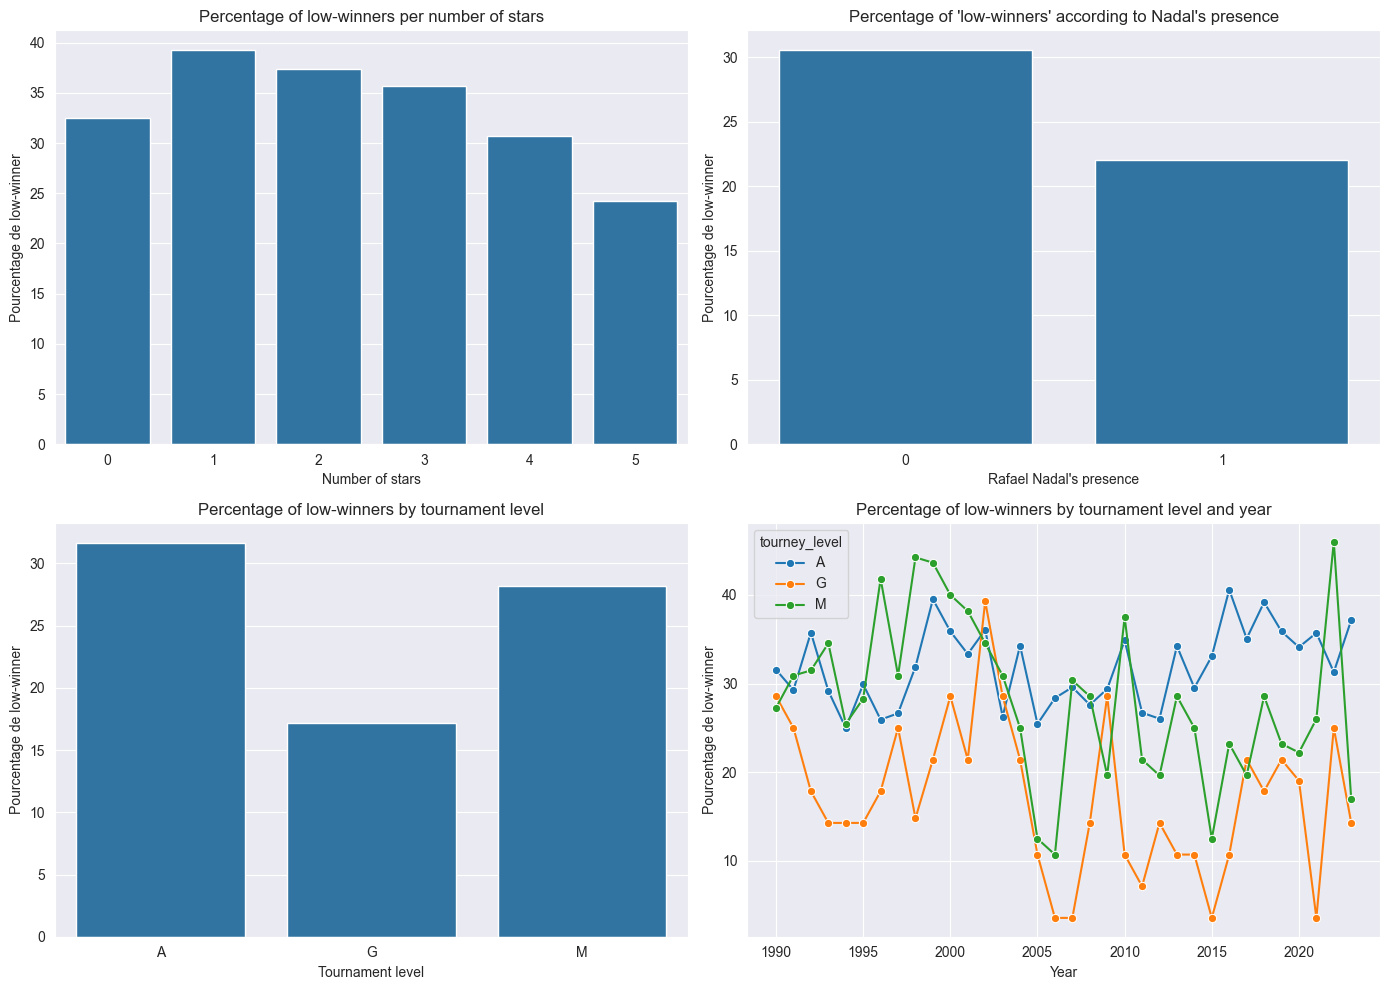

In [42]:
agg_df = df_cleaned_ind.copy().dropna()
# Pourcentage de "low_winners" pour chaque valeur de "number of stars in the tournament"
lwr_stars = agg_df.groupby('num_stars_in_tournament', observed=True)['winner_lower_rank'].mean().reset_index()
lwr_stars['winner_lower_rank'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "Rafael_Nadal_star"
lwr_nadal = agg_df.groupby('Rafael_Nadal_star', observed=True)['winner_lower_rank'].mean().reset_index()
lwr_nadal['winner_lower_rank'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "tourney_level"
lwr_tourney_level = agg_df.groupby('tourney_level', observed=True)['winner_lower_rank'].mean().reset_index()
lwr_tourney_level['winner_lower_rank'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "tourney_level" par année
lwr_tourney_year = agg_df.groupby(['tourney_level', 'year'], observed=True)['winner_lower_rank'].mean().reset_index()
lwr_tourney_year['winner_lower_rank'] *= 100  # Convert to percentage

# Création des graphiques dans une figure (2,2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Graphique 1 : 'num_stars_in_tournament' vs 'winner_low_winner'
sns.barplot(ax=axes[0, 0], x='num_stars_in_tournament', y='winner_lower_rank', data=lwr_stars)
axes[0, 0].set_title("Percentage of low-winners per number of stars")
axes[0, 0].set_xlabel('Number of stars')
axes[0, 0].set_ylabel('Pourcentage de low-winner')
# Graphique 2 : 'Rafael_Nadal_star' vs 'winner_low_winner'
sns.barplot(ax=axes[0, 1], x='Rafael_Nadal_star', y='winner_lower_rank', data=lwr_nadal)
axes[0, 1].set_title("Percentage of 'low-winners' according to Nadal's presence")
axes[0, 1].set_xlabel("Rafael Nadal's presence")
axes[0, 1].set_ylabel("Pourcentage de low-winner")
# Graphique 3 : 'tourney_level' vs 'winner_low_winner'
sns.barplot(ax=axes[1, 0], x='tourney_level', y='winner_lower_rank', data=lwr_tourney_level)
axes[1, 0].set_title("Percentage of low-winners by tournament level")
axes[1, 0].set_xlabel("Tournament level")
axes[1, 0].set_ylabel('Pourcentage de low-winner')
# Graphique 4 : 'tourney_level' et 'year' vs 'winner_low_winner'
sns.lineplot(ax=axes[1, 1], x='year', y='winner_lower_rank', hue='tourney_level', data=lwr_tourney_year, marker='o')
axes[1, 1].set_title("Percentage of low-winners by tournament level and year")
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Pourcentage de low-winner')
# Ajustement de l'affichage
plt.tight_layout()
plt.show()

- Summary of the variables of interest (winner of the match ranked lower than the loser) according to the presence of Star and the level of the tournament.

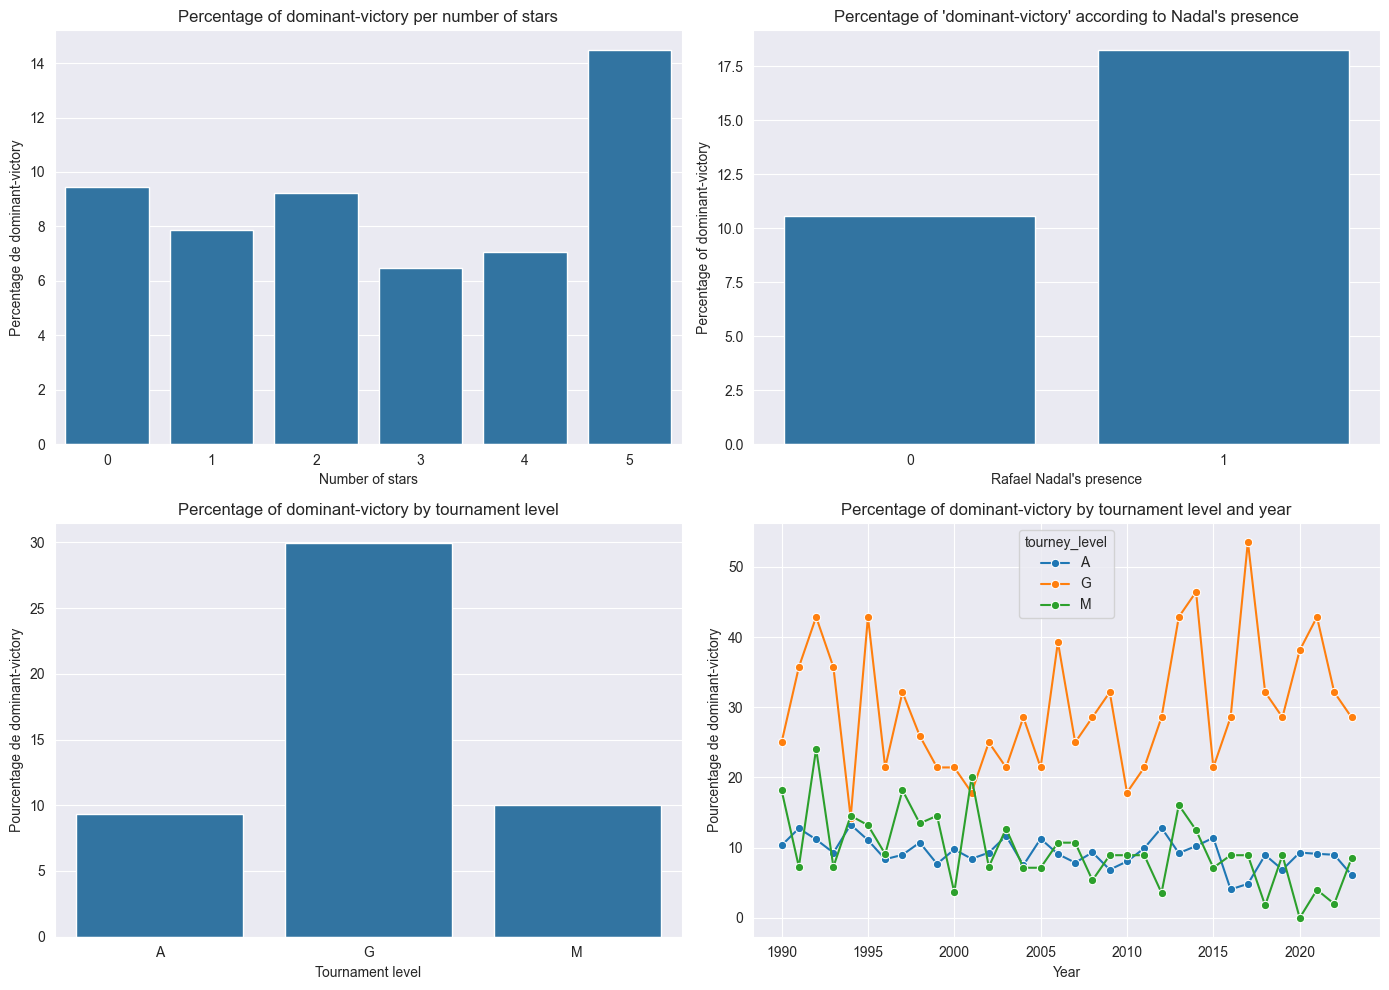

In [43]:
# Pourcentage de "low_winners" pour chaque valeur de "number of stars in the tournament"
vd_stars = df_cleaned_ind.groupby('num_stars_in_tournament', observed=True)['victory_dominant'].mean().reset_index()
vd_stars['victory_dominant'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "Rafael_Nadal_star"
vd_nadal = df_cleaned_ind.groupby('Rafael_Nadal_star', observed=True)['victory_dominant'].mean().reset_index()
vd_nadal['victory_dominant'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "tourney_level"
vd_tourney_level = df_cleaned_ind.groupby('tourney_level', observed=True)['victory_dominant'].mean().reset_index()
vd_tourney_level['victory_dominant'] *= 100  # Convert to percentage
# Pourcentage de "winner_low_winner" pour chaque valeur de "tourney_level" par année
vd_tourney_year = df_cleaned_ind.groupby(['tourney_level', 'year'], observed=True)['victory_dominant'].mean().reset_index()
vd_tourney_year['victory_dominant'] *= 100  # Convert to percentage

# Création des graphiques dans une figure (2,2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Graphique 1 : 'num_stars_in_tournament' vs 'winner_low_winner'
sns.barplot(ax=axes[0, 0], x='num_stars_in_tournament', y='victory_dominant', data=vd_stars)
axes[0, 0].set_title("Percentage of dominant-victory per number of stars")
axes[0, 0].set_xlabel('Number of stars')
axes[0, 0].set_ylabel('Percentage de dominant-victory')
#axes[0, 0].legend().remove()  # Supprime la légende inutile
# Graphique 2 : 'Rafael_Nadal_star' vs 'winner_low_winner'
sns.barplot(ax=axes[0, 1], x='Rafael_Nadal_star', y='victory_dominant', data=vd_nadal)
axes[0, 1].set_title("Percentage of 'dominant-victory' according to Nadal's presence")
axes[0, 1].set_xlabel("Rafael Nadal's presence")
axes[0, 1].set_ylabel("Percentage of dominant-victory")
#axes[0, 1].legend().remove()  # Supprime la légende inutile
# Graphique 3 : 'tourney_level' vs 'winner_low_winner'
sns.barplot(ax=axes[1, 0], x='tourney_level', y='victory_dominant', data=vd_tourney_level)
axes[1, 0].set_title("Percentage of dominant-victory by tournament level")
axes[1, 0].set_xlabel("Tournament level")
axes[1, 0].set_ylabel('Pourcentage de dominant-victory')
#axes[1, 0].legend().remove()  # Supprime la légende inutile
# Graphique 4 : 'tourney_level' et 'year' vs 'winner_low_winner'
sns.lineplot(ax=axes[1, 1], x='year', y='victory_dominant', hue='tourney_level', data=vd_tourney_year, marker='o')
axes[1, 1].set_title("Percentage of dominant-victory by tournament level and year")
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Pourcentage de dominant-victory')
# Ajustement de l'affichage
plt.tight_layout()
plt.show()

- Creation of a regression table for further statistical analysis

In [44]:
# Suppression des colonnes de calcul ou non pertinente pour le suite
columns_to_drop  = ['tourney_id', 'draw_size', 'match_num', 'winner_name',
                    'winner_ht', 'winner_ioc', 'winner_age', 'loser_name',
                    'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 
                    'winner_rank', 'winner_rank_points', 'loser_rank','loser_rank_points', 
                    'winner_sets_won', 'loser_sets_won']
df_reg_ind = df_cleaned_ind.drop(columns=columns_to_drop )

#### Présentation des données finalement retenue après nettoyage de la table de données construite

In [45]:
# Description of each variable (example of interpretation) 
# Quantitative variables
quantitative_vars = ['height_diff', 'age_diff', 'num_stars_in_tournament']
# Dichotomous variables (0 or 1)
dichotomous_vars = ['victory_dominant', 'Rafael_Nadal_star', 'Roger_Federer_star', 'Novak_Djokovic_star', 'Others_star']
# Categorical variables (qualitative)
categorical_vars = ['surface', 'tourney_level','winner_hand', 'round','winner_ioc_grouped', 'draw_size_cat', 'winner_age_cat', 'winner_ht_cat']
# Time or context variables (not used as explanatory variables)
context_vars = ['year', 'tourney_name', 'tourney_date', 'loser_id','winner_id']
# Target variable (dependent/explained) dichotomous
target_lw_win = 'sets_won_low'
target_lw_set = 'winner_lower_rank'
target_dominant = 'victory_dominant'
# Display variable types
print("\nTypes of variables in the database:")
print(f"Quantitatives: {quantitative_vars}")
print(f"Dichotomous: {dichotomous_vars}")
print(f"Categorical: {categorical_vars}")
print(f"Target variable (dichotomous) 1: {target_lw_win}")
print(f"Target variable (explained) 2: {target_lw_set}")
print(f"Target variable (quantitative) 3: {target_dominant}")


Types of variables in the database:
Quantitatives: ['height_diff', 'age_diff', 'num_stars_in_tournament']
Dichotomous: ['victory_dominant', 'Rafael_Nadal_star', 'Roger_Federer_star', 'Novak_Djokovic_star', 'Others_star']
Categorical: ['surface', 'tourney_level', 'winner_hand', 'round', 'winner_ioc_grouped', 'draw_size_cat', 'winner_age_cat', 'winner_ht_cat']
Target variable (dichotomous) 1: sets_won_low
Target variable (explained) 2: winner_lower_rank
Target variable (quantitative) 3: victory_dominant


In [46]:
df_cleaned_ind['year'].nunique()

34

In [47]:
# Nombre total de lignes (matchs)
total_matches = df_reg_ind.shape[0]
# Nombre d'années considérées
total_years = df_reg_ind['year'].nunique()
# Nombre de joueurs uniques (en fonction des gagnants et des perdants)
#total_unique_players = pd.concat([df_cleaned['winner_id'], df_cleaned['loser_id']]).nunique()
print(f"\nTotal de matchs: {total_matches}")
print(f"Total d'années: {total_years}")
#print(f"Nombre de joueurs uniques: {total_unique_players}")


Total de matchs: 12534
Total d'années: 34


    -> Refaire les visualisation de variables d'interet sur les nouvelles variables
    -> Créer la base de régression (transformer Year en dummies)
    -> faire des test statistique de correlation surtoutes les varibables pertinentes de la base
    -> Faire le modèle de survie des dans un tournois des 25% les moins bien classé
    -> Estimé un modèle econometrique adapté a chaque base

### IV - Modelling: Player-oriented approach

#### Survival Analysis Model: 

        -> the performance of players in a tournament is compared in terms of the number of rounds reached depending on whether or not a star is present.

- Survival analysis on tennis players' tournament progress

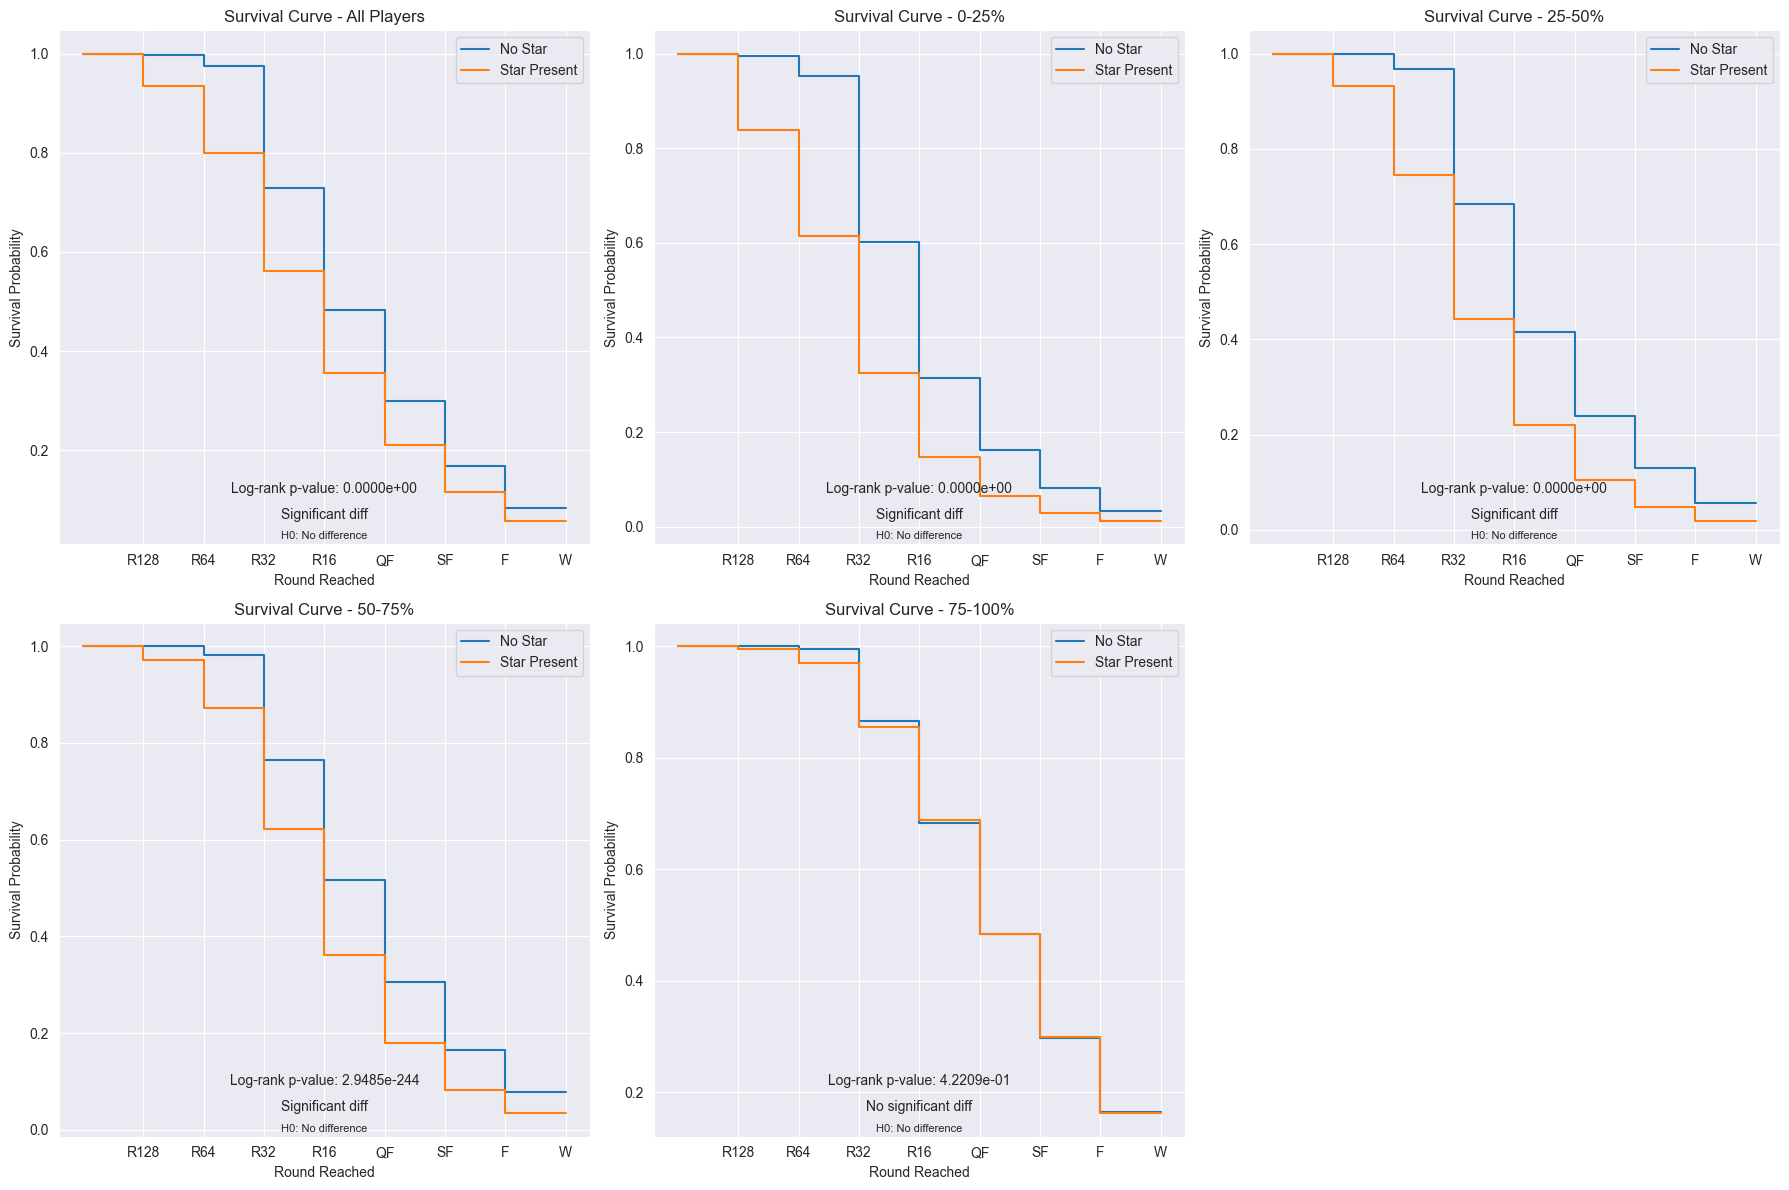

Hypotheses tested:
- Null hypothesis (H0): There is no difference in survival between players in tournaments with and without stars.
- Alternative hypothesis (H1): There is a difference in survival between players in tournaments with and without stars.
Interpretation:
- If p-value < 0.05, we reject H0 and accept H1, indicating a significant difference.
- If p-value >= 0.05, we fail to reject H0, indicating no significant difference.


In [48]:
# Ranking of players in quantile groups according to their sliding point totals
survival_df = df_star_points.copy()
survival_df['quartile_points'] = survival_df.groupby(['tourney_date', 'tourney_name'])['part_points_earned'].transform(
        lambda x: pd.qcut(x.rank(method='first', ascending=False), 4, labels=['75-100%', '50-75%', '25-50%', '0-25%']))
# Selection of the period under consideration
survival_df = survival_df[(survival_df.tourney_date >= "1990-01-01") & 
                        (survival_df.tourney_date <= "2023-12-31")]
#model
survival_analysis(survival_df)

It appears that there is a significant difference in the survival of the lowest-ranked players depending on whether or not there is a star in the tournament, but not for the top players.

### IV - Modelling: player-tournament approach (OLS-LOGIT)

#### Choice of model shape : Homogeneous coefficient vs panel model vs Binomial

    -> Estimation of an econometrics model to evaluate the progression of players in terms of the number of rounds reached in the presence or absence of a star. The survival model estimated above shows that it would be judicious to take into account the type of player involved, in particular by taking into account their class in terms of points.

- Convert the match table into a table player with the players as the statistical unit

In [49]:
# Apply the transformation
df_players = transform_match_to_player(df_cleaned_ind)
# Merge on 'player_id', 'tourney_date', 'tourney_name', and 'player_name'
merged_df = pd.merge(
    df_players,
    survival_df,
    on=['tourney_date', 'tourney_name', 'player_id', 'player_name'],
    how='inner')
# Select the desired columns
selected_columns = [
    'tourney_name', 'player_name', 'surface', 'tourney_level', 'tourney_date',
    'round', 'year', 'cumulative_points', 'part_points_earned', 'star_method_1',
    'star_method_2', 'star_method_3', 'is_star', 'max_round', 'quartile_points',
    'round_num', 'event', 'player_hand', 'num_stars_in_tournament',
    'player_lower_rank', 'Rafael_Nadal_star', 'Roger_Federer_star',
    'Novak_Djokovic_star', 'Others_star', 'height_diff', 'age_diff',
    'player_ioc_grouped', 'draw_size_cat', 'player_age_cat', 'player_ht_cat',
    'victory_dominant', 'sets_won_low']
players_model = merged_df[selected_columns].copy()
players_model.index = merged_df.set_index(['player_id', 'tourney_date']).index

players_model.head()

tourney_name     player_name surface tourney_level  \
player_id tourney_date                                                      
101843    1990-01-01       Adelaide  Sergi Bruguera    Hard             A   
          1990-01-01       Adelaide  Sergi Bruguera    Hard             A   
          1990-01-01       Adelaide  Sergi Bruguera    Hard             A   
          1990-01-01       Adelaide  Sergi Bruguera    Hard             A   
          1990-01-01       Adelaide  Sergi Bruguera    Hard             A   

                       tourney_date round  year  cumulative_points  \
player_id tourney_date                                               
101843    1990-01-01     1990-01-01  RLow  1990                0.0   
          1990-01-01     1990-01-01  RLow  1990                0.0   
          1990-01-01     1990-01-01  RLow  1990                0.0   
          1990-01-01     1990-01-01  RLow  1990                0.0   
          1990-01-01     1990-01-01   R16  1990                0.0   

                        part_points_earned  star_method_1  ...  \
player_id tourney_date                                     ...   
101843    1990-01-01                   0.0          False  ...   
          1990-01-01                   0.0          False  ...   
          1990-01-01                   0.0          False  ...   
          1990-01-01                   0.0          False  ...   
          1990-01-01                   0.0          False  ...   

                        Novak_Djokovic_star  Others_star  height_diff  \
player_id tourney_date                                                  
101843    1990-01-01                      0            0         -2.0   
          1990-01-01                      0            0         -2.0   
          1990-01-01                      0            0         -2.0   
          1990-01-01                      0            0         -2.0   
          1990-01-01                      0            0          5.0   

                       age_diff player_ioc_grouped  draw_size_cat  \
player_id tourney_date                                              
101843    1990-01-01       -1.4        USA-ESP-FRA      18.0-32.0   
          1990-01-01       -1.4        USA-ESP-FRA      18.0-32.0   
          1990-01-01       -1.4        USA-ESP-FRA      18.0-32.0   
          1990-01-01       -1.4        USA-ESP-FRA      18.0-32.0   
          1990-01-01      -10.1        USA-ESP-FRA      18.0-32.0   

                        player_age_cat player_ht_cat victory_dominant  \
player_id tourney_date                                                  
101843    1990-01-01         16.8-23.9   185.0-190.0            False   
          1990-01-01         16.8-23.9   185.0-190.0            False   
          1990-01-01         16.8-23.9   185.0-190.0            False   
          1990-01-01         16.8-23.9   185.0-190.0            False   
          1990-01-01         16.8-23.9   185.0-190.0            False   

                       sets_won_low  
player_id tourney_date               
101843    1990-01-01              0  
          1990-01-01              0  
          1990-01-01              0  
          1990-01-01              0  
          1990-01-01              1  

[5 rows x 32 columns]

In [50]:
# Prepare the data for panel regression
# Convert categorical variables to numeric codes or dummy variables
# players_model = players_model.dropna()

- Setting up the database for panel regression 

In [51]:
# Prepare the data for panel regression
# Convert categorical variables to numeric codes or dummy variables
players_model = ensure_type_conversion(players_model, cat_codes=True)
# Independent variables columns
X_cols_p = ['surface', 'tourney_level', 'player_hand','player_ioc_grouped','draw_size_cat','quartile_points', 
          'is_star','player_lower_rank','player_age_cat', 'player_ht_cat','height_diff', 'age_diff', 
          'Rafael_Nadal_star', 'Roger_Federer_star','Novak_Djokovic_star', 'num_stars_in_tournament',]

- Compare Pooled OLS, Fixe Effect & Random effet

In [52]:
# Dependent variable
y_cols = 'round_num'
# Independent variables
X_df = players_model[X_cols_p]
#Estimate model and statistique test
round_num_models  = estimate_and_compare_models(players_model, X_df, y_cols, count_model=True)

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

player_hand_R

  fe_res = fe_model.fit()
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:255: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level_G, player_hand_R

  fe_time_res = fe_time_model.fit()


Comparaison des AIC :
  Pooled OLS AIC: 304060.77
  Fixed Effect AIC: 291128.13
  Random Effect AIC: 293296.75
  Fixed Time Effect AIC: 284321.49

Résultats du modèle de Poisson :
Poisson AIC: 372475.98
Dispersion Ratio (Variance observée / Moyenne prédite): 0.3622
Pas de surdispersion significative détectée : Le modèle de Poisson est approprié.

Conclusion : L'OLS peut offrir un ajustement similaire ou meilleur que le modèle de Poisson (AIC).

Résultats du Test de Hausman :
Chi-square statistic: 686.2786
P-value: 0.0000e+00
Conclusion: Fixed Effects model is preferred

Résultats du Test de Breusch-Pagan :
LM statistic: 549.4332
P-value: 0.0000e+00
Conclusion: Random Effects model is preferred over Pooled OLS

Vérification de robustesse :
- Assurez-vous qu'il n'y a pas de multicolinéarité parfaite ou de matrice de covariance singulière.
- Les tests sont sensibles aux hypothèses d'homoscedasticité et d'absence d'autocorrélation.



In [53]:
X_cols_pp = ['surface', 'tourney_level', 'player_hand','player_ioc_grouped','draw_size_cat','quartile_points',
          'is_star','player_lower_rank','player_age_cat', 'player_ht_cat','height_diff', 'age_diff',]

- Estimation of the different models compared

In [54]:
print(round_num_models)

                                           Model Comparison                                          
                                       Pooled OLS  Fixed Effects    Random Effects Year Fixed Effects
-----------------------------------------------------------------------------------------------------
Dep. Variable                           round_num      round_num         round_num          round_num
Estimator                               PooledOLS       PanelOLS     RandomEffects           PanelOLS
No. Observations                            94151          94151             94151              94151
Cov. Est.                              Unadjusted     Unadjusted        Unadjusted         Unadjusted
R-squared                                  0.3630         0.2779            0.3710             0.2298
R-Squared (Within)                         0.2586         0.2779            0.2775             0.2647
R-Squared (Between)                        0.2462        -0.1885            0.3986

- Final model

In [55]:
fe_time_model = PanelOLS(players_model['round_num'], X_df, entity_effects=True, time_effects=True, drop_absorbed=True)
fe_time_res = fe_time_model.fit()
print(fe_time_res)

C:\Users\kouno\AppData\Local\Temp\ipykernel_24728\1763350302.py:2: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level.G, player_hand.R

  fe_time_res = fe_time_model.fit()


                          PanelOLS Estimation Summary                           
Dep. Variable:              round_num   R-squared:                        0.2298
Estimator:                   PanelOLS   R-squared (Between):             -0.0293
No. Observations:               94151   R-squared (Within):               0.2647
Date:                Sun, Mar 30 2025   R-squared (Overall):              0.1111
Time:                        11:05:16   Log-likelihood                -1.421e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      855.08
Entities:                        1154   P-value                           0.0000
Avg Obs:                       81.587   Distribution:                F(32,91711)
Min Obs:                       1.0000                                           
Max Obs:                       3637.0   F-statistic (robust):             855.08
                            

### V - Modelling: match-tournament approach (OLS-LOGIT)

#### Choice of model shape : Homogeneous coefficient vs panel model vs ZIB

- Creation of winner_quartile and loser_quartile columns in df_reg_ind

In [56]:
# Associer les quartiles des joueurs avec les gagnants et les perdants dans df_reg_ind
match_model= df_reg_ind.copy()
match_model = match_model.merge(
    merged_df[['tourney_name', 'tourney_date', 'player_id', 'quartile_points']],
    left_on=['tourney_name', 'tourney_date', 'winner_id'],
    right_on=['tourney_name', 'tourney_date', 'player_id'],
    how='left'
).rename(columns={'quartile_points': 'winner_quartile'}).drop('player_id', axis=1)

match_model = match_model.merge(
    merged_df[['tourney_name', 'tourney_date', 'player_id', 'quartile_points']],
    left_on=['tourney_name', 'tourney_date', 'loser_id'],
    right_on=['tourney_name', 'tourney_date', 'player_id'],
    how='left'
).rename(columns={'quartile_points': 'loser_quartile'}).drop('player_id', axis=1)
# Define a MultiIndex on the DataFrame
match_model = match_model.set_index(['tourney_name', 'year'])
match_model.head()

surface tourney_level tourney_date  winner_id winner_hand  \
tourney_name year                                                             
Adelaide     1990    Hard             A   1990-01-01     101843           R   
             1990    Hard             A   1990-01-01     101843           R   
             1990    Hard             A   1990-01-01     101843           R   
             1990    Hard             A   1990-01-01     101843           R   
             1990    Hard             A   1990-01-01     101843           R   

                   loser_id round num_stars_in_tournament  winner_lower_rank  \
tourney_name year                                                              
Adelaide     1990    101632  RLow                       0              False   
             1990    101632  RLow                       0              False   
             1990    101632  RLow                       0              False   
             1990    101632  RLow                       0              False   
             1990    101632  RLow                       0              False   

                   Rafael_Nadal_star  ...                loser_ioc_grouped  \
tourney_name year                     ...                                    
Adelaide     1990                  0  ...  GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI   
             1990                  0  ...  GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI   
             1990                  0  ...  GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI   
             1990                  0  ...  GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI   
             1990                  0  ...  GER-ARG-SWE-AUS-RUS-ITA-CZE-SUI   

                   draw_size_cat  winner_age_cat  loser_age_cat  \
tourney_name year                                                 
Adelaide     1990      18.0-32.0       16.8-23.9      15.5-23.9   
             1990      18.0-32.0       16.8-23.9      15.5-23.9   
             1990      18.0-32.0       16.8-23.9      15.5-23.9   
             1990      18.0-32.0       16.8-23.9      15.5-23.9   
             1990      18.0-32.0       16.8-23.9      15.5-23.9   

                   winner_ht_cat loser_ht_cat victory_dominant sets_won_low  \
tourney_name year                                                             
Adelaide     1990    185.0-190.0  185.0-190.0            False            0   
             1990    185.0-190.0  185.0-190.0            False            0   
             1990    185.0-190.0  185.0-190.0            False            0   
             1990    185.0-190.0  185.0-190.0            False            0   
             1990    185.0-190.0  185.0-190.0            False            0   

                  winner_quartile loser_quartile  
tourney_name year                                 
Adelaide     1990           0-25%          0-25%  
             1990           0-25%          0-25%  
             1990           0-25%          0-25%  
             1990           0-25%          0-25%  
             1990           0-25%          0-25%  

[5 rows x 26 columns]

- Preparation of data and definition of explanatory variables

In [57]:
# Encoding of categorical columns and conversion of Booleans to integers
match_model = ensure_type_conversion(match_model)
# Independent variables columns
X_cols_m = ['round', 'surface', 'tourney_level','winner_hand','winner_ioc_grouped', 
          'loser_ioc_grouped', 'draw_size_cat','loser_quartile', 'winner_quartile',
          'winner_age_cat', 'loser_age_cat', 'winner_ht_cat', 'loser_ht_cat','height_diff', 
          'age_diff', 'Rafael_Nadal_star', 'Roger_Federer_star','Novak_Djokovic_star', 
          'num_stars_in_tournament', ]

##### Target 1 : winner_lower_rank

In [58]:
# Dependent variable
y_cols = 'winner_lower_rank'
# Independent variables
X_df = match_model[X_cols_m]
#Estimate model and statistique test
winner_lower_models  = estimate_and_compare_models(match_model, X_df, y_cols, logit_model=True)

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_res = fe_model.fit()
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:255: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_time_res = fe_time_model.fit()


Comparaison des AIC :
  Pooled OLS AIC: 845041.89
  Fixed Effect AIC: 814053.63
  Random Effect AIC: 814319.82
  Fixed Time Effect AIC: 805688.05

Optimization terminated successfully.
         Current function value: 0.459902
         Iterations 7
Modèle Logit/Probit (binaire) :
Logit AIC: 800721.0646296752

Conclusion : Le modèle Logit/Probit offre un meilleur ajustement que l'OLS (AIC).

Résultats du Test de Hausman :
Chi-square statistic: 48.9070
P-value: 1.8946e-04
Conclusion: Fixed Effects model is preferred

Résultats du Test de Breusch-Pagan :
LM statistic: 523.3887
P-value: 0.0000e+00
Conclusion: Random Effects model is preferred over Pooled OLS

Vérification de robustesse :
- Assurez-vous qu'il n'y a pas de multicolinéarité parfaite ou de matrice de covariance singulière.
- Les tests sont sensibles aux hypothèses d'homoscedasticité et d'absence d'autocorrélation.



- Estimation of the different models compared winner_lower_models

In [59]:
print(winner_lower_models)

                                                  Model Comparison                                                 
                                       Pooled OLS         Fixed Effects        Random Effects    Year Fixed Effects
-------------------------------------------------------------------------------------------------------------------
Dep. Variable                   winner_lower_rank     winner_lower_rank     winner_lower_rank     winner_lower_rank
Estimator                               PooledOLS              PanelOLS         RandomEffects              PanelOLS
No. Observations                           870491                870491                870491                870491
Cov. Est.                              Unadjusted            Unadjusted            Unadjusted            Unadjusted
R-squared                                  0.2748                0.2677                0.2680                0.2649
R-Squared (Within)                         0.2671                0.2677 

- Final model winner_lower_rank

In [60]:
X_df_log = pd.get_dummies(X_df, drop_first=True).astype(float)
logit_probit_model = sm.Logit(match_model['winner_lower_rank'], X_df_log).fit()

Optimization terminated successfully.
         Current function value: 0.460686
         Iterations 7


In [61]:
# Afficher les résultats de l'estimation
print(logit_probit_model.summary())

                           Logit Regression Results                           
Dep. Variable:      winner_lower_rank   No. Observations:               870491
Model:                          Logit   Df Residuals:                   870472
Method:                           MLE   Df Model:                           18
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                  0.2540
Time:                        11:06:08   Log-Likelihood:            -4.0102e+05
converged:                       True   LL-Null:                   -5.3753e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
round                       0.0298      0.002     18.239      0.000       0.027       0.033
surface                    -0.0895      0.003    -27.992      0.000      -0.096      -0.083


In [62]:
# Extraire les coefficients exponentiés (odds ratios) et interpréter
odds_ratios = np.exp(logit_probit_model.params)
conf_int = np.exp(logit_probit_model.conf_int())  # Intervalle de confiance pour les odds ratios

# Afficher les résultats sous forme de table avec odds ratios et intervalles de confiance
results_df = pd.DataFrame({
    'Coefficient': round(logit_probit_model.params, 2),
    'Odds Ratio': round(odds_ratios, 2),
    'Lower CI': round(conf_int[0], 2),
    'Upper CI': round(conf_int[1], 2),
    'P-Value': round(logit_probit_model.pvalues,3)
})
print("\nOdds Ratios with 95% Confidence Intervals:")
star_vars = ['Rafael_Nadal_star', 'Roger_Federer_star', 'Novak_Djokovic_star', 'num_stars_in_tournament']
# Sélection des lignes de results_df avec les noms spécifiés
selected_results_df = results_df.loc[results_df.index.isin(star_vars)]
# Affichage du résultat
print(selected_results_df)


Odds Ratios with 95% Confidence Intervals:
                         Coefficient  Odds Ratio  Lower CI  Upper CI  P-Value
Rafael_Nadal_star              -0.00        1.00      0.98      1.02    0.837
Roger_Federer_star             -0.48        0.62      0.61      0.64    0.000
Novak_Djokovic_star            -0.48        0.62      0.60      0.63    0.000
num_stars_in_tournament        -0.05        0.95      0.95      0.95    0.000


##### Target 2 : victory_dominant

In [63]:
# Dependent variable
y_cols = 'victory_dominant'
# Independent variables
X_df = match_model[X_cols_m]
#Estimate model and statistique test
victory_dominant_models  = estimate_and_compare_models(match_model, X_df, y_cols, logit_model=True)

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_res = fe_model.fit()
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:255: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_time_res = fe_time_model.fit()


Comparaison des AIC :
  Pooled OLS AIC: 504138.75
  Fixed Effect AIC: 469266.16
  Random Effect AIC: 469494.01
  Fixed Time Effect AIC: 463470.14

Optimization terminated successfully.
         Current function value: 0.355731
         Iterations 7
Modèle Logit/Probit (binaire) :
Logit AIC: 619362.1012733191

Conclusion : L'OLS peut offrir un ajustement similaire ou meilleur que le modèle Logit/Probit (AIC).

Résultats du Test de Hausman :
Chi-square statistic: 37.4480
P-value: 6.9712e-03
Conclusion: Fixed Effects model is preferred

Résultats du Test de Breusch-Pagan :
LM statistic: 662.6029
P-value: 0.0000e+00
Conclusion: Random Effects model is preferred over Pooled OLS

Vérification de robustesse :
- Assurez-vous qu'il n'y a pas de multicolinéarité parfaite ou de matrice de covariance singulière.
- Les tests sont sensibles aux hypothèses d'homoscedasticité et d'absence d'autocorrélation.



- Estimation of the different models compared victory_dominant_models

In [64]:
print(victory_dominant_models)

                                                Model Comparison                                               
                                      Pooled OLS        Fixed Effects       Random Effects   Year Fixed Effects
---------------------------------------------------------------------------------------------------------------
Dep. Variable                   victory_dominant     victory_dominant     victory_dominant     victory_dominant
Estimator                              PooledOLS             PanelOLS        RandomEffects             PanelOLS
No. Observations                          870491               870491               870491               870491
Cov. Est.                             Unadjusted           Unadjusted           Unadjusted           Unadjusted
R-squared                                 0.0375               0.0095               0.0096               0.0095
R-Squared (Within)                        0.0056               0.0095               0.0095              

- Final model victory_dominant

In [65]:
X_df_log = pd.get_dummies(X_df, drop_first=True).astype(float)
logit_probit_model = sm.Logit(match_model['victory_dominant'], X_df_log).fit()

Optimization terminated successfully.
         Current function value: 0.362287
         Iterations 7


In [66]:
# Afficher les résultats de l'estimation
print(logit_probit_model.summary())

                           Logit Regression Results                           
Dep. Variable:       victory_dominant   No. Observations:               870491
Model:                          Logit   Df Residuals:                   870472
Method:                           MLE   Df Model:                           18
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                 0.03294
Time:                        11:06:59   Log-Likelihood:            -3.1537e+05
converged:                       True   LL-Null:                   -3.2611e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
round                      -0.0694      0.002    -33.299      0.000      -0.073      -0.065
surface                    -0.2366      0.004    -63.378      0.000      -0.244      -0.229


In [67]:
# Extraire les coefficients exponentiés (odds ratios) et interpréter
odds_ratios = np.exp(logit_probit_model.params)
conf_int = np.exp(logit_probit_model.conf_int())  # Intervalle de confiance pour les odds ratios

# Afficher les résultats sous forme de table avec odds ratios et intervalles de confiance
results_df = pd.DataFrame({
    'Coefficient': round(logit_probit_model.params, 2),
    'Odds Ratio': round(odds_ratios, 2),
    'Lower CI': round(conf_int[0], 2),
    'Upper CI': round(conf_int[1], 2),
    'P-Value': round(logit_probit_model.pvalues,3)
})
print("\nOdds Ratios with 95% Confidence Intervals:")
star_vars = ['Rafael_Nadal_star', 'Roger_Federer_star', 'Novak_Djokovic_star', 'num_stars_in_tournament']
# Sélection des lignes de results_df avec les noms spécifiés
selected_results_df = results_df.loc[results_df.index.isin(star_vars)]
# Affichage du résultat
print(selected_results_df)


Odds Ratios with 95% Confidence Intervals:
                         Coefficient  Odds Ratio  Lower CI  Upper CI  P-Value
Rafael_Nadal_star              -0.15        0.86      0.84      0.88      0.0
Roger_Federer_star             -0.60        0.55      0.53      0.57      0.0
Novak_Djokovic_star             0.22        1.25      1.22      1.28      0.0
num_stars_in_tournament         0.02        1.02      1.01      1.02      0.0


##### Target 3 : sets_won_low

In [68]:
# Dependent variable
y_cols = 'sets_won_low'
# Independent variables
X_df = match_model[X_cols_m]
#Estimate model and statistique test
sets_won_low_models  = estimate_and_compare_models(match_model, X_df, y_cols, count_model=True)

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:249: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_res = fe_model.fit()
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:255: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

tourney_level

  fe_time_res = fe_time_model.fit()


Comparaison des AIC :
  Pooled OLS AIC: 2201761.15
  Fixed Effect AIC: 2167669.24
  Random Effect AIC: 2167942.36
  Fixed Time Effect AIC: 2159972.76

Résultats du modèle de Poisson :
Poisson AIC: 2017163.14
Dispersion Ratio (Variance observée / Moyenne prédite): 1.0348
Surdispersion détectée : Utilisation d'un modèle binomial négatif.

Negative Binomial AIC: 2179995.06
Conclusion : Le modèle de Poisson offre un ajustement similaire ou meilleur que le binomial négatif (AIC).

Résultats du Test de Hausman :
Chi-square statistic: 70.0061
P-value: 9.1769e-08
Conclusion: Fixed Effects model is preferred

Résultats du Test de Breusch-Pagan :
LM statistic: 631.9809
P-value: 0.0000e+00
Conclusion: Random Effects model is preferred over Pooled OLS

Vérification de robustesse :
- Assurez-vous qu'il n'y a pas de multicolinéarité parfaite ou de matrice de covariance singulière.
- Les tests sont sensibles aux hypothèses d'homoscedasticité et d'absence d'autocorrélation.



- Estimation of the different models compared sets_won_low

In [69]:
print(sets_won_low_models)

                                         Model Comparison                                         
                                  Pooled OLS    Fixed Effects    Random Effects Year Fixed Effects
--------------------------------------------------------------------------------------------------
Dep. Variable                   sets_won_low     sets_won_low      sets_won_low       sets_won_low
Estimator                          PooledOLS         PanelOLS     RandomEffects           PanelOLS
No. Observations                      870491           870491            870491             870491
Cov. Est.                         Unadjusted       Unadjusted        Unadjusted         Unadjusted
R-squared                             0.2115           0.2048            0.2054             0.2021
R-Squared (Within)                    0.2019           0.2048            0.2048             0.2045
R-Squared (Between)                   0.3322           0.1102            0.1970             0.1031
R-Squared 

- Final model sets_won_low

In [70]:
# Préparation des données pour le modèle hurdle
X_df_b = pd.get_dummies(X_df, drop_first=True).astype(float)
# Séparation des données en deux parties : zéro et non-zéro
y_b= match_model['sets_won_low']
zero_mask = (y_b == 0)
y_zero = y_b[zero_mask]
y_nonzero = y_b[~zero_mask]
X_zero = X_df_b[zero_mask]
X_nonzero = X_df_b[~zero_mask]

In [71]:
# Modèle Probit pour prédire les zéros (présence/absence de l'événement)
probit_model = sm.Probit(zero_mask.astype(int), X_df_b).fit()
probit_aic = probit_model.aic
print("\nRésultats du modèle Probit (Hurdle pour les zéros) :")
print(probit_model.summary())
print(f"Probit AIC: {round(probit_aic, 2)}")

Optimization terminated successfully.
         Current function value: 0.617046
         Iterations 5

Résultats du modèle Probit (Hurdle pour les zéros) :
                          Probit Regression Results                           
Dep. Variable:           sets_won_low   No. Observations:               870491
Model:                         Probit   Df Residuals:                   870472
Method:                           MLE   Df Model:                           18
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                  0.1074
Time:                        11:08:02   Log-Likelihood:            -5.3713e+05
converged:                       True   LL-Null:                   -6.0176e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
round                       

In [72]:
# Modèle binomial négatif pour prédire les valeurs non nulles
negbin_count_model = sm.GLM(y_nonzero, X_nonzero, family=sm.families.NegativeBinomial()).fit()
negbin_count_aic = negbin_count_model.aic
print("\nRésultats du modèle binomial négatif (Hurdle pour les valeurs positives) :")
print(negbin_count_model.summary())
print(f"Negative Binomial (Hurdle) AIC: {round(negbin_count_aic, 2)}")


Résultats du modèle binomial négatif (Hurdle pour les valeurs positives) :
                 Generalized Linear Model Regression Results                  
Dep. Variable:           sets_won_low   No. Observations:               461784
Model:                            GLM   Df Residuals:                   461765
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.1863e+05
Date:                Sun, 30 Mar 2025   Deviance:                       36467.
Time:                        11:08:05   Pearson chi2:                 3.77e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01099
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [73]:
# Comparaison de l'AIC global en additionnant les deux parties du modèle Hurdle
hurdle_aic = probit_aic + negbin_count_aic
print(f"\nHurdle Model Total AIC: {round(hurdle_aic, 2)}")


Hurdle Model Total AIC: 2711608.8


In [74]:
# Calcul de l'AIC global pour le modèle hurdle binomial négatif
print(f"\nHurdle Model AIC (Probit + Negative Binomial): {round(hurdle_aic, 2)}")
# Conclusion de comparaison basée sur l'AIC
print("\nComparaison des modèles :")
if hurdle_aic < 2145516.29:
    print("Conclusion : Le modèle hurdle binomial négatif fournit un meilleur ajustement global que le modèle OLS basé sur l'AIC.\n")
else:
    print("Conclusion : Le modèle OLS fournit un ajustement similaire ou meilleur que le modèle hurdle binomial négatif.\n")


Hurdle Model AIC (Probit + Negative Binomial): 2711608.8

Comparaison des modèles :
Conclusion : Le modèle OLS fournit un ajustement similaire ou meilleur que le modèle hurdle binomial négatif.



#### VI - Evaluation : Model using Matching approach

In [95]:
from modules.target_modelling import perform_matching_and_estimation
# from sklearn.preprocessing import LabelEncoder

- target = round_num

In [96]:
perform_matching_and_estimation(players_model, 'num_stars_in_tournament', 'round_num', X_cols_pp, is_player_level=True)

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category')
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category')



Results for round_num (Treatment: num_stars_in_tournament):
                            OLS Regression Results                            
Dep. Variable:              round_num   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     1728.
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:14:27   Log-Likelihood:            -1.5201e+05
No. Observations:               94151   AIC:                         3.041e+05
Df Residuals:                   94119   BIC:                         3.044e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

TypeError: argument of type 'int' is not iterable

- winner_lower_rank

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category').cat.codes
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category').cat.codes
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 


Results for winner_lower_rank (Treatment: num_stars_in_tournament):
                           Logit Regression Results                           
Dep. Variable:      winner_lower_rank   No. Observations:               870491
Model:                          Logit   Df Residuals:                   870474
Method:                           MLE   Df Model:                           16
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                  0.2524
Time:                        12:31:39   Log-Likelihood:            -4.0185e+05
converged:                       True   LL-Null:                   -5.3753e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.4416      0.015    -28.830      0.000      -0.472      -0.412
round                  

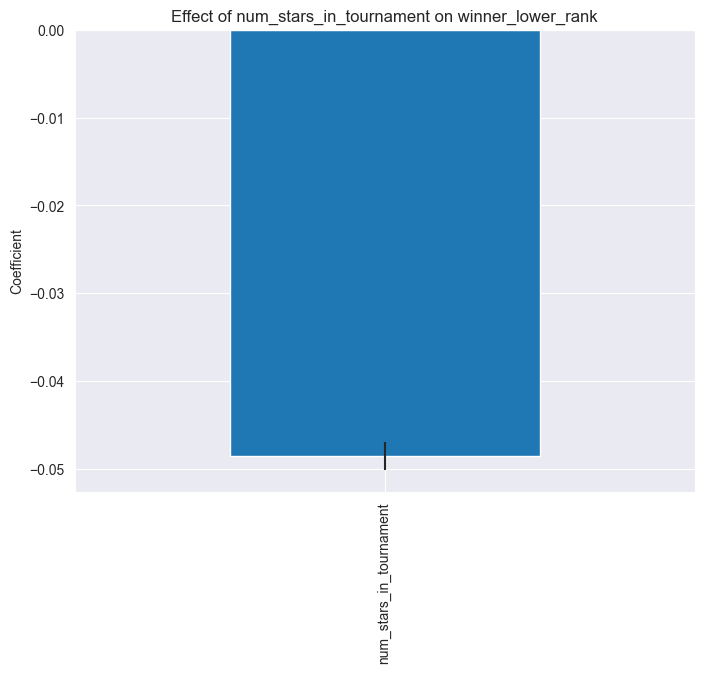

In [78]:
perform_matching_and_estimation(match_model_p, 'num_stars_in_tournament', 'winner_lower_rank', X_cols_mp)

- sets_won_low

C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category').cat.codes
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].astype('category').cat.codes
C:\Users\kouno\Desktop\Projet Tournois\modules\target_modelling.py:529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 


Results for sets_won_low (Treatment: num_stars_in_tournament):
                            OLS Regression Results                            
Dep. Variable:           sets_won_low   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                 1.442e+04
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:36:56   Log-Likelihood:            -1.1020e+06
No. Observations:              870491   AIC:                         2.204e+06
Df Residuals:                  870474   BIC:                         2.204e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

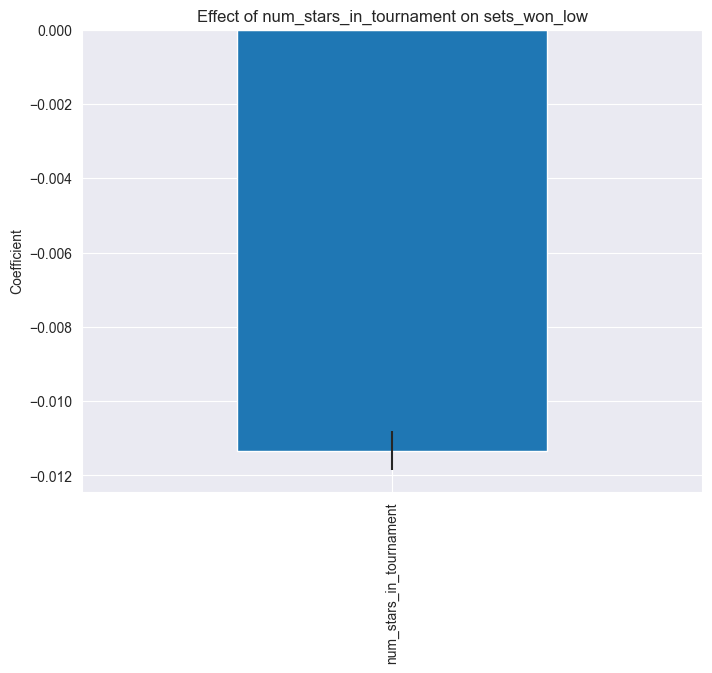

In [83]:
perform_matching_and_estimation(match_model_p, 'num_stars_in_tournament', 'sets_won_low', X_cols_mp)

In [ ]:
#Intiliation
players_model_p = players_model.copy()
# Prepare the data for panel regression
players_model_p = ensure_type_conversion(players_model_p, cat_codes=True)
# Independent variables columns
X_cols_pp = ['surface', 'tourney_level', 'player_hand','player_ioc_grouped','draw_size_cat','quartile_points',
          'is_star','player_lower_rank','player_age_cat', 'player_ht_cat','height_diff', 'age_diff',]


match_model_p = match_model.copy()
# Encoding of categorical columns and conversion of Booleans to integers
match_model_p = ensure_type_conversion(match_model_p)
# Independent variables columns
X_cols_mp = ['round', 'surface', 'tourney_level','winner_hand','winner_ioc_grouped',
          'loser_ioc_grouped', 'draw_size_cat','loser_quartile', 'winner_quartile',
          'winner_age_cat', 'loser_age_cat', 'winner_ht_cat', 'loser_ht_cat','height_diff',
          'age_diff' ]

# RECHANTILLONAGE (BOOTSTRAP)

In [ ]:
# Sauvegarder les tables générées si nécessaire
# df_matches_enhanced.to_excel('data/match_star_table.xlsx', index=False)
# df_yearly_top_stars.to_excel('data/yearly_top_stars.xlsx', index=False)